# Age and Gender Recognition with Tensoflow 

#### This project uses Google's inception v3 model with Tensorflow to predict the age and the gender of a person in a portrait, after training the model using 20000 wikipedia.org portraits from the [IMDB-WIKI dataset](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/). While an accuracy of 90% is achieved for gender (male/female) classification, the inception v3 model is unable to accurately predict age when trained on the wikipedia protraits database, with a Mean Absolute Error of 9.1 years. 

<p align="center"><img src="./images/predictions_examples.png" width = "1000"></p>


## Introduction


Determining the age and gender of a person using pictures or video can have numerous applications, including targeted recommendations in stores, adapting the contents of a video for younger audiance, security control, etc. 

The purpose of this project is to estimate the gender and age of a person based on a portrait, using Google's inception v3 model with Tensorflow. The [inception v3 model](https://www.tensorflow.org/tutorials/images/image_recognition) is a deep convolutional neural network designed for computer vision classification, specifically trained to classify pictures of objects in the [ImageNet database](https://en.wikipedia.org/wiki/ImageNet). This model is trained on about 20000 images of faces obtained from [wikipedia.org](https://en.wikipedia.org/wiki/Main_Page), with gender and age information available for each picture. 

Tensorflow offers a [tutorial](https://www.tensorflow.org/hub/tutorials/image_retraining) for retraining the inception v3 model using new categories provided by the user. In particular, the [retrain.py](https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py) file provided for this tutorial is used in this project for creating bottlenecks for each picture (i.e. the 2048 outputs of the second-to-last layer of the convolutional neural network, which is essentially a method for converting a picture into 2048 useful features for classifying images) and for retraining the model for gender categories.


## Description and main results

### Data preparation

The pictures and metadata were downloaded from this [link](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar).

The data is first cleaned by converting the date of birth from Matlab serial date number to pandas datetime. This allows the calculation of the age of the person in the picture by calculating the difference between the date when the picture was taken (obtained from metadata) and their date of birth.

Then, a random sample of 20000 images (10000 males and 10000 females) from this dataset is selected and the images are moved to a folder based on their gender (male & female folders) to allow the inception v3 re-training process by Tensorflow.

Because this sample of 20000 images was not perfectly clean (some portraits gender are mislabeled, mainly because of the face extraction algorithm to generate the portraits from wikipedia pictures), it became necessary to remove the images with mislabeled gender manually. Since this is obviously a very time consuming and boring task (about 2 or 3 hours spent scanning rows of images to spot mislabeled gender), the cleaned dataset containing 19218 images is provided in this repository.

### Gender predictions

#### Gender predictions using Tensorflow

Then, using Tensorflow's retrain module, the gender of each person in the selected portrait database is predicted using cross-validation. For each fold, the remaining images are moved to a training folder and the inception v3 model is retrained on the specified labels for the training images. Then, for each image in the fold, the gender is predicted. Finally, the training data is moved back to the original folder. Because the most-time consuming part of this process is the generation of bottlenecks by the inception v3 model for each image, they are also included in the repository. 

The cross-validated accuracy obtained by the re-trained model for predicting the gender in the portaits is 89.2%.

By looking at the mislabbeled images in the figure below, it can be clearly seen that males with long hair are often mislabeled as females by the model, even when they clearly possess masculine facial features (strong jaw, facial hair, etc.). 

<p align="center"><img src="./images/mislabelled_gender.png" width = "1000"></p>

On the contrary, women with long blond hair are often successfully labelled with a confidence level close to 100%, as shown in the figure below.

<p align="center"><img src="./images/most_confident_predictions_gender.png" width = "1000"></p>

In fact, if the average faces of a male and of a female are calculated and plotted (see figure below), it can be clearly seen that, despite the blur caused by averaging thousands of unaligned pictures, the typical male has short hair while the typical female has long hair.

<p align="center"><img src="./images/average_female_male.png" width = "700"></p>

When plotting the renormalized difference between the average face of a female and that of a male, it is possible to identify the main difference between typical females and males: females have darker spots along the side due to their typicaly long hair, their chin is lighter because they lack facial hair, their lips are redder (possibly due to the use of lipstick) and their eyes are darker (also possibly because of makeup). Incidentaly, their clothes are slightly redder than that of males, which is probably not a very relevant criterion for classifying the gender of a person.

<p align="center"><img src="./images/diff_female_male.png" width = "350"></p>

The figure below shows the confusion matrix for cross-validated gender predictions. Most errors correspond to females labelled as men by the model, and indeed, it can be observed that the average mislabelled female portrait looks very similar to the average correclty labelled male portrait, including the average color of clothes. By looking at mislabelled female portraits individually, they often include short hair or a baseball cap (most portraits with a baseball cap in the Wikipedia database are male sportmen, thereby introducing a bias).

<p align="center"><img src="./images/confusion_matrix_gender.png" width = "580"></p>

All these observations show that the re-trained model base its decision mainly on spatial features and is probably unable to detect each facial feature independently to make its decisions (e.g. size of chin relative to the face, structure of skin, etc...) as humans usually do. Indeed, for almost every portrait in the database, the gender can be recognized almost immediately by a human.

#### Gender predictions with Gradient Boosting classifier

By using the bottlenecks created by the inception v3 model for each picture as features, it is also possible to use another model to predict gender. In this project, the [light Gradient Boosting Machine (lightGBM)](https://lightgbm.readthedocs.io/en/latest/) classifier model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) algorithm, is used for its performance in both speed and accuracy for such problems instead of inception's model last Softmax activation layer. 

After optimizing the lightGBM model's [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)) (number of trees, depth of trees, minimum number of images per leaf, L1 and L2 regularization, etc.) using a self-made GridSearch function, the cross-validation accuracy for prediciting gender is increased to 90.3% (instead of 89.2% for the inception model alone). 

As shown in the figure below, the corresponding area under the [receiver operating characteristic curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) (ROC AUC) is equal to 0.967 for the cross-validated data and 0.996 for the training data. This large difference shows that the model is [overfitting the training data](https://en.wikipedia.org/wiki/Overfitting) (i.e. it "memorizes" the training data thanks to the large number of free parameters in the model), but its accuracy is nevertheless optimized for unseen data.

<p align="center"><img src="./images/ROC_AUC_gender_LGBM.png" width = "600"></p>


### Age predictions

Using the same bottlenecks as the ones generated by the retrain module for the gender labels (bottlenecks created by the inception model are independent of the training labels), it is also possible to train a lightGBM regressor model to predict the age of the person in each image.

Once opmimized using a GridSearch function, the lightGBM regressor model was able to predict the age in the portraits with a [Mean Absolute Error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE) of 8.7 years, and a [Root-Mean-Square Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) of 11.5 years. By comparison, [the best algorithms](https://pdfs.semanticscholar.org/c570/2b45686cc4eb357627bbc8bb05e8c7281e8d.pdf) for predicting the age using face images lead to a MAE of around 3 years. This relatively poor performance by the inception v3 model may be explained by the fact that it has been optimized and pre-trained to classify thousands of item categories and was not designed for such age estimation regression task. 

Nevertheless, this model does perfrom significantly better than a random guess, as can be demonstrated by shuffling the target data (i.e. age) in the dataset. In this case, while the model is able to overfit the training data to the target data (Pearson's correlation coefficient: 0.99), this correlation disappears for the validation data (Pearson's correlation coefficient: 0.0). The associated MAE and RMSE are 13.8 years and 17.6 years, respectively.




## Installation

This 


## Credits

Before this step, it is necessary to replace "_sys.exit(main(argv))" by "main(argv)" in app.py (/Anaconda3/Lib/site-packages/tensorflow/python/platform/app.py) to avoid a SystemError (as sys.exit function attempts to close python which is prevented by jupyter).

In [1]:
# Import main modules
import pandas as pd
import numpy as np
import scipy
import scipy.io
from datetime import datetime, timedelta
import shutil
import os
import os.path
import time
import sys
import argparse

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import PIL
from PIL import ImageEnhance

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, roc_curve, auc
from lightgbm import LGBMRegressor, LGBMClassifier

# Importing Tensorflow modules
import tensorflow as tf
import tensorflow_hub as hub

# Import functions from retrain.py and label_image.py
import retrain
import label_image

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
## Change graphics ##

# Setting Seaborn default style 
sns.set(font_scale=1.4)
sns.set_style("white")

# Reverting to old color palette
pal = sns.color_palette("deep")
pal = pal.as_hex()
pal[1], pal[2], pal[3] = pal[2], pal[3], pal[1]
sns.set_palette(pal)

In [3]:
## Parameters ##

# Bins for gender recognition
gender_bins = ["male", "female"]

# Minimum and maximum age for age recognition (to remove absurd values such as centuries old portraits)
min_age = 0
max_age = 100

# Definition of columns for metadata files
columns_wiki = ["dob", "year_photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Default Flag values for retrain.py
FLAGS = argparse.Namespace()
FLAGS.image_dir = ""
FLAGS.output_graph = './retrained_graph.pb'
FLAGS.output_labels = './output_labels.txt'
FLAGS.summaries_dir = './summaries/'
FLAGS.how_many_training_steps = 4000
FLAGS.learning_rate = 0.01
FLAGS.testing_percentage = 20
FLAGS.validation_percentage = 20
FLAGS.eval_step_interval = 10
FLAGS.train_batch_size = 100
FLAGS.test_batch_size = -1
FLAGS.validation_batch_size = 100
FLAGS.print_misclassified_test_images = True
FLAGS.model_dir = "."
FLAGS.bottleneck_dir = "bottlenecks"
FLAGS.final_tensor_name = "final_result"
FLAGS.flip_left_right = False
FLAGS.random_crop = 0
FLAGS.random_scale = 0
FLAGS.random_brightness = 0
FLAGS.intermediate_store_frequency = 0
FLAGS.tfhub_module = "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"
FLAGS.saved_model_dir = ""

In [4]:
## Functions ##

# This function converts metadata Matlab files to pandas dataframe
def convert_mat_dataframe(mat_file, columns, dict_key):
    mat = scipy.io.loadmat(mat_file)
    mat_data = mat[dict_key][0][0]
    df = pd.DataFrame()
    for index, item in enumerate(mat_data):
        if len(item[0]) == len(mat_data[0][0]): # Columns are only added to the dataframe if all the data is available
            df[columns[index]] = item[0]
    return(df)


# This function converts the Matlab serial date number to pandas datetime
def convert_date(Matlab_date):
    try:
        python_dt = datetime.fromordinal(int(Matlab_date)) + timedelta(days=Matlab_date%1) - timedelta(days = 366)
    except OverflowError:
        python_dt = None
    return python_dt


# This function converts the numpy arrays in the metadata Matlab files to its first element
def select_first_element(array):
    if len(array) > 0:
        return array[0]
    else:
        return np.NaN

    
# This function calculates the age of the person the year the photo was taken
def calculate_age(df):
    age_list = []
    counter = 0
    for index, row in df.iterrows():
        counter += 1
        progress(counter, len(df))
        # Since data of photo is not known precisely, it is assumed to be July 1st
        date_photo = datetime(year = row["year_photo_taken"], month = 7, day = 1)
        date_of_birth = row["dob_py"]
        if date_of_birth.month < date_photo.month:
            age = int(date_photo.year - date_of_birth.year)
        else:
            age = int(date_photo.year - date_of_birth.year - 1)
        age_list.append(age)
    return age_list


# This function clarifies the gender in the daraframe (1.0 is replaced by "male" and 0.0 is replaced by "female")
def clarify_gender(gender):
    if gender == 1.0:
        gender = "male"
    else:
        gender = "female"
    return gender


# This function display the progress percentage of the current task
def progress(index, lenght):
    progress = index/lenght*100
    if progress != 100:
        sys.stdout.write("Progress: %d%%   \r" % (progress) )
        sys.stdout.flush()
    else:
        sys.stdout.write("Progress: %d%%   \n" % (progress) )

        
# This function creates a sample of images in folders organized by gender to allow training with Tensorflow 
def create_verified_gender_training_folder(df, origin = "./data/wiki/", folder = "./data/verified_gender/", nb_samples = 10000):
    counter = 0
    # Creating verified data folders
    if not os.path.exists(folder):
        os.mkdir(folder)
    for gender in gender_bins:
        if not os.path.exists(folder+str(gender)):
            os.mkdir(folder+str(gender))
        
        if nb_samples > len(df[df["gender"] == gender]):
            nb_samples = len(df[df["gender"] == gender])
            
        # Selecting random sample of images for each gender and copying them to verified data folders
        df_gender = df[df["gender"] == gender].sample(n=nb_samples, random_state = 1)
        counter_gender = 0
        for index, row in df_gender.iterrows():
            counter = counter + 1
            progress(counter, len(gender_bins) * nb_samples)
            old_path = origin+row["full_path"]
            new_file_name = str(row.name)+"_"+row["name"]+"_"+row["gender"]+"_"+str(row["age"])+".jpg"
            new_path = folder+str(gender)+"/"+new_file_name
            try:
                shutil.copy(old_path, new_path)
                counter_gender += 1
            except:
                print("File missing :", old_path)
        print(str(counter_gender) + " " + gender + " images moved to training folder")


# This function defines a more explicit file name for the image file
def define_new_file_name(row):
    return str(row.name)+"_"+row["name"]+"_"+row["gender"]+"_"+str(row["age"])+".jpg"


# This function defines the new training folder for the image depending on the selected feature
def define_new_path(row, path, feature):
    return path+row[feature]+"/"+str(row.name)+"_"+row["name"]+"_"+row["gender"]+"_"+str(row["age"])+".jpg"


# This function verifies if the picture is in the verified_data folder
def is_verified(row, folder, feature):
    if os.path.exists(row["new_path_gender"]):
        return 1
    else:
        return 0


# This function (adapted from the Tensorflow label_image.py) returns the probabilities that the dataset labels 
# are correct based on the corresponding image using cross-validation on the training data
def cv_classify_images(df, feature, feature_bins, 
                       path_data, path_training = "./data/tmp/", 
                       model_folder = "./model/", model_name = "model",
                       info_level = 0, input_height = 299, input_width = 299, cv = 5):
    
    # Creating new features in dataframe
    label_file = model_folder+"output_labels.txt"
    labels = label_image.load_labels(label_file)
    for label in labels:
        df["probability_"+feature+"_"+label] = np.NaN
    df["correct_"+feature+"_probability"] = np.NaN
    
    # Creating temporary training directory
    if not os.path.exists(path_training):
        os.mkdir(path_training)
    for gender in gender_bins:
        if not os.path.exists(path_training+str(gender)):
            os.mkdir(path_training+str(gender))
    
    # Iteration on Cross-Validation folds
    kfold = KFold(n_splits=cv, shuffle=True, random_state = 42)
    counter_CV = 0
    for train_index, val_index in kfold.split(df):
        counter_CV += 1
        print("CV iteration:", counter_CV)

        # Definition of training and validation sets for the current fold
        train_df = df.iloc[train_index].copy()
        val_df = df.iloc[val_index].copy()
        
        # Moving each file into temporary folder for training
        print("Moving images into training folder")
        counter_move_file = 0
        for index, row in train_df.iterrows():
            counter_move_file += 1
            progress(counter_move_file, len(train_df))
            file_name = path_data+row[feature]+"/"+row["new_file_name"]
            new_path = path_training+row[feature]+"/"+row["new_file_name"]
            try:
                shutil.move(file_name, new_path)
            except:
                print("File missing :", file_name)
        print("Moving images into training folder : done")


        print("Retraining classifier")        
        FLAGS.how_many_training_steps = 500
        FLAGS.model_dir = model_folder
        FLAGS.output_graph = model_folder+"retrained_graph.pb"  
        FLAGS.output_labels = model_folder+"output_labels.txt"
        # No summaries are created because they cannot be removed until jupyter kernel is killed
        FLAGS.summaries_dir = ""
        FLAGS.final_tensor_name = model_name
        FLAGS.image_dir = path_training
        retrain.FLAGS = FLAGS
        
        # Setting verbosity level
        tf.logging.INFO = info_level
        
        # Training new model using training images
        tf.app.run(main=retrain.main)
        print("Retraining classifier : done")

        
        print("Classifying validation images")
        model_file = model_folder+"retrained_graph.pb"
        input_mean = 0
        input_std = 255
        input_layer = "Placeholder"
        output_layer = model_name
        graph = label_image.load_graph(model_folder+"retrained_graph.pb")
        input_name = "import/" + input_layer
        output_name = "import/" + output_layer
        
        counter_val = 0
        results_list = []
        prob_correct_label_list = []
        for index, row in val_df.iterrows():
            counter_val += 1
            progress(counter_val, len(val_df))

            file_name = path_data+row[feature]+"/"+row["new_file_name"]
            
            # Reading, resizing and processing image
            t = label_image.read_tensor_from_image_file(
                file_name,
                input_height=input_height,
                input_width=input_width,
                input_mean=input_mean,
                input_std=input_std)
        
            input_operation = graph.get_operation_by_name(input_name)
            output_operation = graph.get_operation_by_name(output_name)
        
            # Predicting label corresponding to image
            with tf.Session(graph=graph) as sess:
                results = sess.run(output_operation.outputs[0], {
                    input_operation.outputs[0]: t
                })
            results = np.squeeze(results)
            results_list.append(results)
            prob_correct_label = results[labels.index(row[feature])]
            prob_correct_label_list.append(prob_correct_label)

        df["correct_"+feature+"_probability"].iloc[val_index] = prob_correct_label_list

        for index, label in enumerate(labels):
            df["probability_"+feature+"_"+label].iloc[val_index] = np.asarray(results_list)[:,index]
            
        print("Classifying validation images : done")

        
        print("Moving back training images")
        for index, row in train_df.iterrows():
            file_name = "./data/verified_gender/"+row["gender"]+"/"+row["new_file_name"]
            new_path = "./data/tmp/"+row["gender"]+"/"+row["new_file_name"]
            try:
                shutil.move(new_path, file_name)
            except:
                print("File missing :", new_path)
        print("Moving back training images : done")
        print("")

    return df


# This function displays the images with the worst classification probability values
def display_worst_probability(df, feature, path_data, rows = 2, width = 299, height = 299, best = False):
    if best == False:
        df = df.sort_values(by = ["correct_"+feature+"_probability"])[0:rows*5]
        title = "Images with worst gender probability predictions"
    else:
        df = df.sort_values(by = ["correct_"+feature+"_probability"], ascending = False)[0:rows*5]
        title = "Images with best gender probability predictions"
    fig = plt.figure(figsize = (20,20*rows/5))
    plt.suptitle(title)
    axes = [fig.add_subplot(rows, 5, i + 1) for i in range(5*rows)]
    counter = 0
    for index, row in df.iterrows():
        ax = axes[counter]
        counter += 1
        im = PIL.Image.open(path_data+row[feature]+"/"+row["new_file_name"]).convert('RGBA')
        im = im.resize((width, height), PIL.Image.BILINEAR)
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.text(10, -35, row["name"], verticalalignment = "center", horizontalalignment = "left", color = "black", size = 13)
        if row["correct_"+feature+"_probability"] > 0.5:
            color_gender = pal.as_hex()[1]
            predicted_gender = row[feature]
            prediction_prob = row["correct_"+feature+"_probability"]
        else:
            color_gender = pal.as_hex()[2]
            prediction_prob = 1 - row["correct_"+feature+"_probability"]
            if row[feature] == "female":
                predicted_gender = "male"
                
            else:
                predicted_gender = "female"
        ax.text(10, -15, "Predicted gender: "+ predicted_gender +" ("+str(round(prediction_prob*100,1))+"%)", verticalalignment = "center", horizontalalignment = "left", color = color_gender, size = 12)
    plt.subplots_adjust(wspace = 0.05, hspace = 0.2)
    plt.show()

    
# This function generates and displays the average image given a list of images, with renormalization of the RGB pixels
# so that the minimum is 0 and the maximum value is 255
def display_average_image(list_images, width = 299, height = 299):
    sum_images = np.zeros((width, height,3))
    counter = 0
    # Summing each pixel array (width*height*3 RGB colors)
    for image in list_images:
        im = PIL.Image.open(image)
        im = im.resize((width, height), PIL.Image.BILINEAR)
        im_array = np.asarray(im)
        # Keeping only RGB images (removes grey scale images)
        if im_array.shape == (width, height, 3):
            counter += 1
            sum_images += im_array 
    avg_images = sum_images / counter
    # Renormalization to ensure minimum value at 0 and maximum value at 255
    avg_images = (avg_images - np.min(avg_images))
    avg_images = avg_images/np.max(avg_images)*255
    avg_images = PIL.Image.fromarray(avg_images.astype('uint8'))
    sharpened = ImageEnhance.Sharpness(avg_images)
    sharpened = sharpened.enhance(1.0)
    sharpened = np.asarray(sharpened)

    # Display image
    plt.figure(figsize = (8,8))
    plt.imshow(sharpened)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    
# This function generates and displays the difference between the average images of two lists of images,
# with the possibility to renormalize the difference to enhance the difference between pixels.
def display_difference_average_image(list_images1, list_images2, width = 299, height = 299, renormalize = False, title = None):
    sum_images = np.zeros((width, height,3))
    counter = 0
    # Summing each pixel array (width*height*3 RGB colors)
    for image in list_images1:
        im = PIL.Image.open(image)
        im = im.resize((width, height), PIL.Image.BILINEAR)
        im_array = np.asarray(im)
        # Keeping only RGB images (removes grey scale images)
        if im_array.shape == (width, height, 3):
            counter += 1
            sum_images += im_array 
    avg_images1 = sum_images / counter

    sum_images = np.zeros((width, height,3))
    counter = 0
    # Summing each pixel array (width*height*3 RGB colors)
    for image in list_images2:
        im = PIL.Image.open(image)
        im = im.resize((width, height),PIL.Image.BILINEAR)
        im_array = np.asarray(im)
        # Keeping only RGB images (removes grey scale images)
        if im_array.shape == (width, height, 3):
            counter += 1
            sum_images += im_array 
    avg_images2 = sum_images / counter
    
    #avg_diff = avg_images1 - avg_images2
    diff = (127 + (avg_images1 - avg_images2))/255

    # Renormalization to ensure minimum value at 0 and maximum value at 255
    if renormalize == True:
        diff = (diff - np.min(diff))
        diff = diff/np.max(diff)*255
        diff = PIL.Image.fromarray(diff.astype('uint8'))
        diff = ImageEnhance.Sharpness(diff)
        diff = diff.enhance(1.0)
        diff = np.asarray(diff)
    plt.figure(figsize = (8,8))
    if title != None:
        plt.suptitle(title, y = 0.95)
    plt.imshow(diff)
    plt.xticks([])
    plt.yticks([])
    plt.show()

    
# This function reads the bottlenecks files generated by Tensorflow for use in retraining with other models
def read_bottlenecks(df, path_bottlenecks, feature1 = "gender", feature2 = "age"):
    list_bottlenecks = []
    counter = 0
    labels = ["new_file_name"] + list(range(1,2049))
    bottlenecks = pd.DataFrame(columns  = labels)
    for index, row in df.iterrows():
        counter +=1
        progress(counter, len(df))
        file = path_bottlenecks+row[feature1]+"/"+row["new_file_name"]+"_https~tfhub.dev~google~imagenet~inception_v3~feature_vector~1.txt"
        file_bottlenecks = pd.read_csv(open(file, "r"), header = None, names  = range(1,2049))
        file_bottlenecks["new_file_name"] = row["new_file_name"]
        bottlenecks = bottlenecks.append(file_bottlenecks)
    return bottlenecks


# This function filters the dataframe to ensure that the range_age is evenly distributed (to avoid bias)
def stratify_age_data(df, ranges_age = [10, 20, 30, 40, 50, 60, 70, 100], sample_size = 1000):
    new_df = pd.DataFrame(columns = df.columns)
    df = df[(df["age"] > ranges_age[0]) & (df["age"] < ranges_age[-1])]
    for index, age in enumerate(ranges_age[:-1]):
        df_age = df[(df["age"] > ranges_age[index]) & (df["age"] < ranges_age[index +1])]
        if len(df_age) > sample_size:
            df_age = df_age.sample(n = sample_size)
        new_df = new_df.append(df_age)
    return new_df

# This function displays a random sample of images from the dataset with the associated gender and age predictions
def display_predictions_sample(df, path_data, feature = "gender", model_gender=None, model_age=None, sample_size = 15, width = 299, height = 299):
    fig = plt.figure(figsize = (20,14))
    axes = [fig.add_subplot(3, 5, i + 1) for i in range(sample_size)]
    counter = 0
    #pal_GnRe = sns.color_palette("coolwarm", 6)
    pal_GnRe = sns.blend_palette([pal[1], pal[3], pal[2]], 3)
    for index, row in df.sample(n=sample_size).iterrows():
        ax = axes[counter]
        counter += 1
        im = PIL.Image.open(path_data+row[feature]+"/"+row["new_file_name"]).convert('RGBA')
        im = im.resize((width, height), PIL.Image.BILINEAR)
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.text(10, -50, row["name"], verticalalignment = "center", horizontalalignment = "left", color = "black", size = 13)
        if row["correct_"+feature+"_probability"] > 0.5:
            color_gender = pal.as_hex()[1]
            predicted_gender = row[feature]
            prediction_prob = row["correct_"+feature+"_probability"]
        else:
            color_gender = pal.as_hex()[2]
            prediction_prob = 1 - row["correct_"+feature+"_probability"]
            if row[feature] == "female":
                predicted_gender = "male"
                
            else:
                predicted_gender = "female"

        ax.text(10, -30, "Predicted gender: "+ predicted_gender +" ("+str(round(prediction_prob*100,1))+"%)", verticalalignment = "center", horizontalalignment = "left", color = color_gender, size = 12)
        error_color = min(2,abs(int((row["age_x"] - row["predicted_age"])/5)))
        color_age = pal_GnRe.as_hex()[abs(error_color)]
        ax.text(10, -10, "Predicted age: "+str(round(row["predicted_age"],1)) +" ("+"actual age: "+str(row["age_x"])+")", verticalalignment = "center", horizontalalignment = "left", color = color_age, size = 12)
    plt.subplots_adjust(wspace = 0.05, hspace = 0.2)
    plt.show()

In [5]:
# Converting metadata Matlab file to pandas dataframe
print("Reading metadata file")
wiki_metadata = convert_mat_dataframe("./data/wiki/wiki.mat", columns_wiki, "wiki")
print("Reading metadata file: done")

Reading metadata file
Reading metadata file: done


In [6]:
# Converting date of birth from Matlab serial date number to pandas datetime
print("Converting date of birth format")
wiki_metadata["dob_py"] = wiki_metadata["dob"].apply(convert_date)
print("Converting date of birth format: done")

Converting date of birth format
Converting date of birth format: done


In [7]:
# Removing rows with invalid date of birth
old_size_wiki = len(wiki_metadata)
wiki_metadata = wiki_metadata[wiki_metadata["dob_py"].notna()]
new_size_wiki = len(wiki_metadata)
print(old_size_wiki - new_size_wiki, "rows removed due to invalid date of birth")

0 rows removed due to invalid date of birth


In [8]:
# Removing missing values and unnecessary numpy array levels
wiki_metadata["name"] = wiki_metadata["name"].apply(select_first_element)
wiki_metadata["full_path"] = wiki_metadata["full_path"].apply(select_first_element)
wiki_metadata["face_location"] = wiki_metadata["face_location"].apply(select_first_element)
wiki_metadata = wiki_metadata.dropna(subset = wiki_metadata.drop(["second_face_score"], axis = 1).columns)

In [9]:
# Calculating age when photo was taken
print("Calculating age for each photo in the database")
old_size_wiki = len(wiki_metadata)
wiki_metadata["age"] = calculate_age(wiki_metadata)
wiki_metadata = wiki_metadata[(wiki_metadata["age"] >= min_age) & (wiki_metadata["age"] < max_age)]
new_size_wiki = len(wiki_metadata)
print(old_size_wiki - new_size_wiki, "rows removed due to invalid age")
print("Calculating age for each photo in the database: done")

Calculating age for each photo in the database


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


Progress: 100%   
1653 rows removed due to invalid age
Calculating age for each photo in the database: done


In [10]:
# Clarifying gender class
wiki_metadata["gender"] = wiki_metadata["gender"].apply(clarify_gender)

In [11]:
# Creating verified gender training folder (will overwrite existing folder)
#create_verified_gender_training_folder(wiki_metadata, origin = "./data/wiki/", folder = "./data/verified_gender/", nb_samples=10000)

In [12]:
# Adding new file name and paths
print("Defining more explicit file name")
wiki_metadata["new_file_name"] = wiki_metadata.apply(define_new_file_name, axis = 1)
wiki_metadata["new_path_gender"] = wiki_metadata.apply(define_new_path , args = ("./data/verified_gender/", "gender", ), axis = 1)
print("Defining more explicit file name: done")

Defining more explicit file name
Defining more explicit file name: done


In [ ]:
# Checking if photo is in verified folder for gender
print("Selecting images in verified folder")
wiki_metadata["gender_is_verified"] = wiki_metadata.apply(is_verified, args = ("./data/verified_gender/", "gender", ), axis = 1)
wiki_metadata = wiki_metadata[wiki_metadata["gender_is_verified"] == 1]
print("Selecting images in verified folder: done")

Selecting images in verified folder
Selecting images in verified folder: done


In [ ]:
# Classifying gender for each portrait image in the verified gender dataset
wiki_metadata = cv_classify_images(df = wiki_metadata, feature = "gender", feature_bins = gender_bins, 
                       path_data = "./data/verified_gender/", path_training = "./data/tmp/", 
                       model_folder = "./model/", model_name = "model",
                       info_level = 0, input_height = 299, input_width = 299, cv = 5)

CV iteration: 1
Moving images into training folder
Progress: 100%   
Moving images into training folder : done
Retraining classifier
Converted 378 variables to const ops.
Retraining classifier : done
Classifying validation images
Progress: 100%   


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Classifying validation images : done
Moving back training images
Moving back training images : done

CV iteration: 2
Moving images into training folder
Progress: 100%   
Moving images into training folder : done
Retraining classifier
Converted 378 variables to const ops.
Retraining classifier : done
Classifying validation images
Progress: 100%   
Classifying validation images : done
Moving back training images
Moving back training images : done

CV iteration: 3
Moving images into training folder
Progress: 100%   
Moving images into training folder : done
Retraining classifier
Converted 378 variables to const ops.
Retraining classifier : done
Classifying validation images
Progress: 100%   
Classifying validation images : done
Moving back training images
Moving back training images : done

CV iteration: 4
Moving images into training folder
Progress: 100%   
Moving images into training folder : done
Retraining classifier
Converted 378 variables to const ops.
Retraining classifier : done
C

In [ ]:
# Calculation of CV accuracy for gender predictions
accuracy = 100*len(wiki_metadata[wiki_metadata["correct_gender_probability"] > 0.5])/len(wiki_metadata["correct_gender_probability"])
print("Cross-Validation accuracy for gender predictions: %0.1f%%" % accuracy)

The retrained Inception convolution network using around 20000 portraits from Wikipedia (10000 males and 10000 females) is able to predict with a 89.2% accuracy the gender of the person in the image. 

In [ ]:
# Backing up dataframe to csv format
#wiki_metadata.to_csv("./data/wiki_metadata.csv", index = False)

In [282]:
# Reloading dataframe from csv file
wiki_metadata2 = pd.read_csv("./data/verified_wiki.csv")

In [283]:
wiki_metadata = wiki_metadata.merge(wiki_metadata2[["name", "correct_gender_probability"]], on = "name")

In [ ]:
# Displaying the images with the worst correct gender probability
display_worst_probability(wiki_metadata, feature = "gender", path_data = "./data/verified_gender/", rows = 2)

In [ ]:
# Displaying the images with the worst correct gender probability for females
display_worst_probability(wiki_metadata[wiki_metadata["gender"] == "female"], feature = "gender", path_data = "./data/verified_gender/", rows = 5)

In [ ]:
# Displaying the images with the worst correct gender probability for males
display_worst_probability(wiki_metadata[wiki_metadata["gender"] == "male"], feature = "gender", path_data = "./data/verified_gender/", rows = 5)

In [ ]:
# Displaying the images with the best correct gender probability
display_worst_probability(wiki_metadata, feature = "gender", path_data = "./data/verified_gender/", rows = 2, best = True)

In [ ]:
# Displaying the images with the best correct gender probability for males
display_worst_probability(wiki_metadata[wiki_metadata["gender"] == "male"], feature = "gender", path_data = "./data/verified_gender/", rows = 5, best = True)

In [ ]:
# Defining lists of male and female images
list_images_male = wiki_metadata[wiki_metadata["gender"] == "male"]["new_path_gender"]
list_images_female = wiki_metadata[wiki_metadata["gender"] == "female"]["new_path_gender"]

In [ ]:
# Displaying the average image of a male
display_average_image(list_images_male)

In [ ]:
# Displaying the average image of a female
display_average_image(list_images_female)

In [ ]:
# Average female and male portraits
fig = plt.figure(figsize = (16, 8))
plt.xticks([0.25, 0.75], ["Female", "Male"], size = 16)
plt.yticks([])
sns.despine(bottom = True, left = True)

ax1 = fig.add_subplot(1, 2, 1)
im = PIL.Image.open("./images/average_female.png")
ax1.imshow(im)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis("off")

ax2 = fig.add_subplot(1, 2, 2)
im = PIL.Image.open("./images/average_male.png")
ax2.imshow(im)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis("off")

plt.suptitle("Average female and male portraits", y = 0.92)
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)

plt.show()

In [ ]:
# Displaying the average difference between a female and a male, with and without renormalization
display_difference_average_image(list_images_female, list_images_male, renormalize=True, title = "Difference between average female and male portraits (normalized)")
display_difference_average_image(list_images_female, list_images_male, renormalize=False, title = "Difference between average female and male portraits (not normalized)")

In [ ]:
# Defining lists of images for comparison purpose (male and female true positives and false negatives)
list_male_ok = wiki_metadata[(wiki_metadata["correct_gender_probability"] > 0.5) &  (wiki_metadata["gender"] == "male")]["new_path_gender"]
list_male_notok = wiki_metadata[(wiki_metadata["correct_gender_probability"] < 0.5) &  (wiki_metadata["gender"] == "male")]["new_path_gender"]
list_female_ok = wiki_metadata[(wiki_metadata["correct_gender_probability"] > 0.5) &  (wiki_metadata["gender"] == "female")]["new_path_gender"]
list_female_notok = wiki_metadata[(wiki_metadata["correct_gender_probability"] < 0.5) &  (wiki_metadata["gender"] == "female")]["new_path_gender"]

In [ ]:
# Displaying the average image of a male, with correct prediction by the model
display_average_image(list_male_ok)

In [ ]:
# Displaying the average image of a male, with incorrect prediction by the model
display_average_image(list_male_notok)

In [ ]:
# Displaying the average image of a female, with correct prediction by the model
display_average_image(list_female_ok)

In [ ]:
# Displaying the average image of a female, with incorrect prediction by the model
display_average_image(list_female_notok)

In [ ]:
# Confusion matrix with average portrait for each catagory (male / female & correctly labelled / mislabelled)
fig = plt.figure(figsize = (9.8, 10))
plt.xlabel("Predicted gender", size = 16)
plt.ylabel("Actual gender", size = 16)
plt.xticks([0.25, 0.75], ["Female", "Male"], size = 16)
plt.yticks([0.25, 0.75], ["Male", "Female"], rotation = 90, size = 16)
sns.despine(bottom = True, left = True)

ax1 = fig.add_subplot(2, 2, 1)
im = PIL.Image.open("./images/correct_female.png")
ax1.imshow(im)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis("off")
ax1.text(150, 420, "n = " + str(len(list_female_ok)) + " (" + str(round(len(list_female_ok)/len(wiki_metadata)*100,1)) + "% )", verticalalignment = "center", horizontalalignment = "left", color = "white", size = 16)

ax2 = fig.add_subplot(2, 2, 2)
im = PIL.Image.open("./images/incorrect_female.png")
ax2.imshow(im)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.axis("off")
ax2.text(150, 420, "n = " + str(len(list_female_notok)) + " (" + str(round(len(list_female_notok)/len(wiki_metadata)*100,1)) + "% )", verticalalignment = "center", horizontalalignment = "left", color = "white", size = 16)

ax3 = fig.add_subplot(2, 2, 3)
im = PIL.Image.open("./images/incorrect_male.png")
ax3.imshow(im)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.axis("off")
ax3.text(150, 420, "n = " + str(len(list_male_notok)) + " (" + str(round(len(list_male_notok)/len(wiki_metadata)*100,1)) + "% )", verticalalignment = "center", horizontalalignment = "left", color = "white", size = 16)

ax4 = fig.add_subplot(2, 2, 4)
im = PIL.Image.open("./images/correct_male.png")
ax4.imshow(im)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.axis("off")
ax4.text(150, 420, "n = " + str(len(list_male_ok)) + " (" + str(round(len(list_male_ok)/len(wiki_metadata)*100,1)) + "% )", verticalalignment = "center", horizontalalignment = "left", color = "white", size = 16)


plt.suptitle("Confusion matrix for gender prediction", y = 0.92)
plt.subplots_adjust(wspace = 0.01, hspace = 0.01)

plt.show()

In [ ]:
# Displaying the average difference between images of females that have been correctly and incorrectly labeled by the model
display_difference_average_image(list_female_ok, list_female_notok, renormalize=True, title = "Difference between correctly labelled and mislabelled female protraits (normalized)")
display_difference_average_image(list_female_ok, list_female_notok, renormalize=False)

In [ ]:
# Displaying the average difference between images of males that have been correctly and incorrectly labeled by the model
display_difference_average_image(list_male_ok, list_male_notok, renormalize=True)
display_difference_average_image(list_male_ok, list_male_notok, renormalize=False)

# Retraining inception model with other machine learning models

Instead of retraining the last layer of the inception neural network model using Tensorflow, it is possible to use bottlenecks data generated by Tensorflow as features for faster and more complex models.

In particular, the lightGBM algorithm is used to train on bottlenecks data and predict the gender and age of the portrait. This model is selected because of its speed and perfromance. In practice, it can perform cross-validation prediction in a few minutes, instead of several hours for the Tensorflow model.

In [ ]:
# Reading bottlenecks data into a new dataframe
bottlenecks = read_bottlenecks(wiki_metadata, path_bottlenecks = "./bottlenecks/", feature1 = "gender", feature2 = "age")

In [ ]:
# Merging the two dataframes together
wiki_metadata = wiki_metadata.merge(bottlenecks, on= "new_file_name")

In [ ]:
# Creating dummy variables for gender (gender_male and gender_female) to allow training by the LightGBM model
dummies = pd.get_dummies(wiki_metadata["gender"])
wiki_metadata = pd.concat([wiki_metadata, dummies], axis = 1)

In [ ]:
# Creating filtered dataframe to ensure uniform age distribution
wiki_metadata_filtered = stratify_age_data(wiki_metadata, ranges_age = [10, 20, 30, 40, 50, 60, 70, 100], sample_size = 1000)

In [ ]:
# Definition of features for training and predictions (bottlenecks)
features = list(range(1,2049))

In [ ]:
wiki_metadata.head()

In [ ]:
#wiki_metadata.to_csv("./data/wiki_metadata.csv", index = True)

In [ ]:
#Default LightGBM parameters
estimator_param = {}
estimator_param["boosting_type"]="gbdt"
estimator_param["num_leaves"]=1000
estimator_param["max_depth"]=5
estimator_param["learning_rate"]=0.1
estimator_param["n_estimators"]=50000
estimator_param["subsample_for_bin"]=200000
estimator_param["objective"]="binary"
estimator_param["class_weight"]=None
estimator_param["min_split_gain"]=0.5
estimator_param["min_child_weight"]=0.001
estimator_param["min_child_samples"]=40
estimator_param["subsample"]=0.8
estimator_param["subsample_freq"]=0
estimator_param["bagging_freq"]=1
estimator_param["colsample_bytree"]=0.2
estimator_param["reg_alpha"]=20.0
estimator_param["reg_lambda"]=0.0
estimator_param["random_state"]=2
estimator_param["n_jobs"]=7
estimator_param["silent"]=True
estimator_param["importance_type"]="split"

In [ ]:
# Function for grid search for the LGBM classifier algorithm
def GridSearch_lgb_classifier(X, y, param_grid, cv = 5, predict = False):
    combinations= [[]]
    params = []
    for key, vals in param_grid.items():
        combinations = [i+[j] for i in combinations for j in vals]
        params.append(key)
    for comb in combinations:
        # Definition of parameters used for gridsearch iteration
        print("Hyperparameters:")
        for index, param in enumerate(params):
            print(param, ":", comb[index])
            estimator_param[param] = comb[index]
        
        # Cross validation
        kfold = KFold(n_splits=cv, shuffle=True, random_state = 2)
        roc_auc_val_list = []
        roc_auc_train_list = []
        accuracy_train_list = []
        accuracy_val_list = []
        fpr_train_list = []
        tpr_train_list = []
        fpr_val_list = []
        tpr_val_list = []
        best_ntree_list = []
        predictions_list = []
        counter = 0
        df_train = pd.DataFrame(index = X.index)
        df_val = pd.DataFrame(index = X.index)
        cv_predict = pd.DataFrame(index = X.index)
        cv_predict["predict_proba"] = np.NaN
        for train_index, val_index in kfold.split(X, y):
            counter += 1
            df_train[str(counter)] = np.NaN
            df_val[str(counter)] = np.NaN
            # Definition of training and validation sets for Kfold
            train_X = X.iloc[train_index]
            train_y = y.iloc[train_index]
            val_X = X.iloc[val_index]
            val_y = y.iloc[val_index]
            # Definition of model
            lgb = LGBMClassifier(boosting_type=estimator_param["boosting_type"],
                                 num_leaves=estimator_param["num_leaves"], 
                                 max_depth=estimator_param["max_depth"],
                                 learning_rate=estimator_param["learning_rate"],
                                 n_estimators=estimator_param["n_estimators"], 
                                 subsample_for_bin=estimator_param["subsample_for_bin"],
                                 objective=estimator_param["objective"],
                                 class_weight=estimator_param["class_weight"],
                                 min_split_gain=estimator_param["min_split_gain"],
                                 min_child_weight=estimator_param["min_child_weight"], 
                                 min_child_samples=estimator_param["min_child_samples"],
                                 subsample=estimator_param["subsample"],
                                 subsample_freq=estimator_param["subsample_freq"],
                                 bagging_freq = estimator_param["bagging_freq"],
                                 colsample_bytree=estimator_param["colsample_bytree"],
                                 reg_alpha=estimator_param["reg_alpha"],
                                 reg_lambda=estimator_param["reg_lambda"],
                                 random_state=estimator_param["random_state"],
                                 n_jobs=estimator_param["n_jobs"],
                                 silent=estimator_param["silent"], 
                                 importance_type=estimator_param["importance_type"],
                                )
            # Training the model on the training data with early stropping with the validation set
            lgb.fit(train_X, train_y, early_stopping_rounds=100, eval_set = [(val_X, val_y)], eval_metric="error", verbose =0)
            # Predictions on training and validation data for Kfold
            predictions_train = lgb.predict_proba(train_X, num_iteration = lgb.best_iteration_)
            predictions_val = lgb.predict_proba(val_X, num_iteration = lgb.best_iteration_)
            if predict == True:
                cv_predict["predict_proba"].iloc[val_index] = predictions_val[:,1]
            # Metrics
            fpr_train, tpr_train, threshold = roc_curve(train_y, predictions_train[:,1])
            fpr_val, tpr_val, threshold = roc_curve(val_y, predictions_val[:,1])
            roc_auc_train = auc(fpr_train, tpr_train)
            roc_auc_val = auc(fpr_val, tpr_val)
            accuracy_train  = accuracy_score(train_y, predictions_train[:,1].round())
            accuracy_val  = accuracy_score(val_y, predictions_val[:,1].round())
            print("CV %0.1i : Accuracy: %0.3f (n_trees: %0.1i)" % (counter, accuracy_val, lgb.best_iteration_))
            roc_auc_train_list.append(roc_auc_train)
            roc_auc_val_list.append(roc_auc_val)
            best_ntree_list.append(round(np.mean(lgb.best_iteration_)))
            fpr_train_list.append(fpr_train)
            tpr_train_list.append(tpr_train)
            fpr_val_list.append(fpr_val)
            tpr_val_list.append(tpr_val)
            accuracy_train_list.append(accuracy_train)
            accuracy_val_list.append(accuracy_val)

        avg_auc_train = np.mean(roc_auc_train_list)
        avg_auc_val = np.mean(roc_auc_val_list)
        std_auc_val = np.std(roc_auc_val_list)
        avg_accuracy_val = np.mean(accuracy_val_list)
        std_accuracy_val = np.std(accuracy_val_list)
        best_nb_iter = round(np.mean(best_ntree_list))
        print("Cross-Validation Accuracy: %0.4f +/- %0.4f (n_trees: %0.1i)" % (avg_accuracy_val, std_accuracy_val * 2, best_nb_iter))
                
        fig, ax = plt.subplots(figsize=(10,9))
        plt.title("Receiver operating characteristic for training and validation data with Gradient Boosting model", y = 1.03)
        for iteration in range(cv):
            if iteration == 0:
                ax.plot(fpr_train_list[iteration], tpr_train_list[iteration], label = 'Train data (AUC = %0.3f)' % avg_auc_train, color = pal.as_hex()[0])
                ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], label = 'Validation data (AUC = %0.3f)' % avg_auc_val, color = pal.as_hex()[1])
            else:
                ax.plot(fpr_train_list[iteration], tpr_train_list[iteration] , color = pal.as_hex()[0])
                ax.plot(fpr_val_list[iteration], tpr_val_list[iteration], color = pal.as_hex()[1])
        ax.plot([0, 1], [0, 1], dashes = (6,4), color = pal.as_hex()[2], label = "Random decision (AUC = 0.500)")
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.xlim(0,1)
        plt.ylim(0,1)
        sns.despine()
        plt.legend(loc = 'lower right')
        plt.show()
        
        if predict == True:
            return cv_predict

In [ ]:
# Optimized hyperparameters obtained using Grid Search
param_grid_gender = {}
param_grid_gender["max_depth"] = [5]
param_grid_gender["min_child_samples"] = [100]
param_grid_gender["subsample"] = [0.4]
param_grid_gender["subsample_freq"]=[1.0]
param_grid_gender["colsample_bytree"]=[1.0]
param_grid_gender["reg_alpha"] = [1, 2, 5, 10]
param_grid_gender["reg_lambda"] = [50, 75, 100, 125, 150]
param_grid_gender["learning_rate"] = [0.1]
param_grid_gender["random_state"]=[2]
param_grid_gender["n_estimators"]=[10000]


In [ ]:
# Cross validation prediction with optimized hyperparameters
GridSearch_lgb_classifier(wiki_metadata[features], wiki_metadata["female"], param_grid_gender, cv = 5, predict = False)

In [364]:
wiki_metadata["female_probability_lgbm"] = predictions_gender
wiki_metadata["correct_gender_probability_lgbm"] = 0.0
wiki_metadata.loc[wiki_metadata["gender"] == "female", "correct_gender_probability_lgbm"] = wiki_metadata["female_probability_lgbm"]
wiki_metadata.loc[wiki_metadata["gender"] == "male", "correct_gender_probability_lgbm"] = 1 - wiki_metadata["female_probability_lgbm"]

# Application to age prediction

The same bottlenecks can also be used to create a regression model (in this case lightGBM regressor) to predict the age in the portrait.

In [313]:
def GridSearch_lgb_regressor(X, y, param_grid, cv, predict = False, early_stopping = True):
    combinations= [[]]
    params = []
    for key, vals in param_grid.items():
        combinations = [i+[j] for i in combinations for j in vals]
        params.append(key)
    for comb in combinations:
        # Definition of parameters used for gridsearch iteration
        print("Hyperparameters:")
        for index, param in enumerate(params):
            print(param, ":", comb[index])
            estimator_param[param] = comb[index]
        
        # Cross validation
        kfold = KFold(n_splits=cv, shuffle=True, random_state = 2)
        rmse_train_list = []
        rmse_val_list = []
        mae_train_list = []
        mae_val_list = []
        spearman_train_list = []
        spearman_val_list = []
        roc_auc_train_list = []
        accuracy_train_list = []
        accuracy_val_list = []
        fpr_train_list = []
        tpr_train_list = []
        fpr_val_list = []
        tpr_val_list = []
        best_ntree_list = []
        counter = 0
        df_train = pd.DataFrame(index = X.index)
        df_val = pd.DataFrame(index = X.index)
        cv_predict = pd.DataFrame(index = X.index)
        cv_predict["predict_proba"] = np.NaN
        for train_index, val_index in kfold.split(X, y):
            counter += 1
            df_train[str(counter)] = np.NaN
            df_val[str(counter)] = np.NaN
            # Definition of training and validation sets for Kfold
            train_X = X.iloc[train_index]
            train_y = y.iloc[train_index]
            val_X = X.iloc[val_index]
            val_y = y.iloc[val_index]
            # Definition of model
            lgb = LGBMRegressor(#boosting_type=estimator_param["boosting_type"],
                                # num_leaves=estimator_param["num_leaves"], 
                                max_depth=estimator_param["max_depth"],
                                learning_rate=estimator_param["learning_rate"],
                                n_estimators=estimator_param["n_estimators"], 
                                # subsample_for_bin=estimator_param["subsample_for_bin"],
                                objective=estimator_param["objective"],
                                # class_weight=estimator_param["class_weight"],
                                # min_split_gain=estimator_param["min_split_gain"],
                                # min_child_weight=estimator_param["min_child_weight"], 
                                min_child_samples=estimator_param["min_child_samples"],
                                subsample=estimator_param["subsample"],
                                subsample_freq=estimator_param["subsample_freq"],
                                # bagging_freq = estimator_param["bagging_freq"],
                                colsample_bytree=estimator_param["colsample_bytree"],
                                reg_alpha=estimator_param["reg_alpha"],
                                reg_lambda=estimator_param["reg_lambda"],
                                random_state=estimator_param["random_state"],
                                n_jobs=estimator_param["n_jobs"],
                                # silent=estimator_param["silent"], 
                                # importance_type=estimator_param["importance_type"],
                                )
            
            if early_stopping == True:
                lgb.fit(train_X, train_y, early_stopping_rounds=100, eval_set = [(val_X, val_y)], eval_metric="rmse", verbose =0)
                best_iteration = lgb.best_iteration_
            else:
                lgb.fit(train_X, train_y, verbose =0)
                best_iteration = estimator_param["n_estimators"]
            predictions_train = lgb.predict(train_X, num_iteration = best_iteration)
            predictions_val = lgb.predict(val_X, num_iteration = best_iteration)
            rmse_train = mean_squared_error(train_y, predictions_train)**(1/2)
            rmse_val = mean_squared_error(val_y, predictions_val)**(1/2)
            print("CV fold #%0.1i (n_trees: %0.1i)" % (counter, best_iteration))
            print("Root Mean Squared Error for training data: %0.3f / validation data: %0.3f" % (rmse_train, rmse_val))
            mae_train = mean_absolute_error(train_y, predictions_train)
            mae_val = mean_absolute_error(val_y, predictions_val)
            print("Mean Absolute Error for training data: %0.3f / validation data: %0.3f" % (mae_train, mae_val))
            spearman_train = scipy.stats.spearmanr(train_y, predictions_train)
            spearman_val = scipy.stats.spearmanr(val_y, predictions_val)
            print("Spearman's rank correlation coefficient for training data: %0.3f / validation data: %0.3f" % (spearman_train[0], spearman_val[0]))
            plt.scatter(train_y, predictions_train)
            plt.scatter(val_y, predictions_val)
            plt.plot([0,100], [0,100], dashes = (4,6))
            plt.xlim(0,100)
            plt.ylim(0,100)
            plt.show()

            rmse_train_list.append(rmse_train)
            rmse_val_list.append(rmse_val)
            mae_train_list.append(mae_train)
            mae_val_list.append(mae_val)
            spearman_train_list.append(spearman_train[0])
            spearman_val_list.append(spearman_val[0])
            best_ntree_list.append(best_iteration)
            
            if predict == True:
                cv_predict["predict_proba"].iloc[val_index] = predictions_val

        avg_rmse_val = np.mean(rmse_val_list)
        std_rmse_val = np.std(rmse_val_list)
        avg_rmse_train = np.mean(rmse_train_list)
        std_rmse_train = np.std(rmse_train_list)
        avg_mae_val = np.mean(mae_val_list)
        std_mae_val = np.std(mae_val_list)
        avg_mae_train = np.mean(mae_train_list)
        std_mae_train = np.std(mae_train_list)

        avg_spearman_train = np.mean(spearman_train_list)
        avg_spearman_val = np.mean(spearman_val_list)

        best_nb_iter = round(np.mean(best_ntree_list))
        
        print("Cross-Validation resuls: (average n_trees: %0.1i)" %best_nb_iter)
        print("Root Mean Squared Error for training data: %0.3f +/- %0.3f/ validation data: %0.3f +/- %0.3f" % (avg_rmse_train, std_rmse_train, avg_rmse_val, std_rmse_val))
        print("Mean Absolute Error for training data: %0.3f +/- %0.3f/ validation data: %0.3f +/- %0.3f" % (avg_mae_train, std_mae_train, avg_mae_val, std_mae_val))
        print("Spearman's rank correlation coefficient for training data: %0.3f / validation data: %0.3f" % (avg_spearman_train, avg_spearman_val))
        print("")        
        if predict == True:
            return cv_predict

In [314]:
# Optimized hyperparameters obtained using Grid Search
param_grid_age = {}
param_grid_age["max_depth"] = [5]
param_grid_age["min_child_samples"] = [5]
param_grid_age["subsample"] = [1.0]
param_grid_age["subsample_freq"]=[1]
param_grid_age["colsample_bytree"]=[1.0]
param_grid_age["reg_alpha"] = [100]
param_grid_age["reg_lambda"] = [10]
param_grid_age["learning_rate"] = [0.1]
param_grid_age["random_state"]=[2]
param_grid_age["objective"]=["regression"]
param_grid_age["n_estimators"]=[5000]


Hyperparameters:
max_depth : 5
min_child_samples : 5
subsample : 1.0
subsample_freq : 1
colsample_bytree : 1.0
reg_alpha : 100
reg_lambda : 10
learning_rate : 0.1
random_state : 2
objective : regression
n_estimators : 5000
CV fold #1 (n_trees: 709)
Root Mean Squared Error for training data: 2.655 / validation data: 11.664
Mean Absolute Error for training data: 2.015 / validation data: 8.820
Spearman's rank correlation coefficient for training data: 0.983 / validation data: 0.651


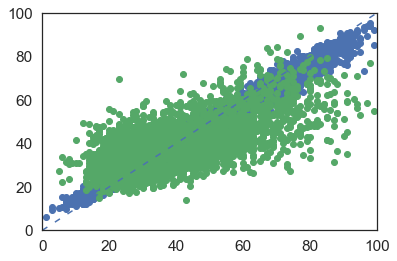

CV fold #2 (n_trees: 1056)
Root Mean Squared Error for training data: 1.675 / validation data: 11.532
Mean Absolute Error for training data: 1.286 / validation data: 8.622
Spearman's rank correlation coefficient for training data: 0.993 / validation data: 0.648


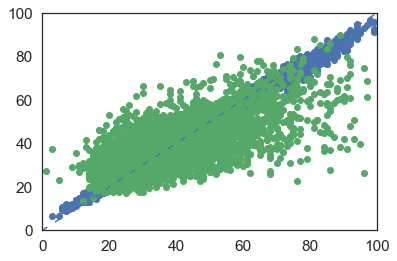

CV fold #3 (n_trees: 1416)
Root Mean Squared Error for training data: 1.233 / validation data: 11.627
Mean Absolute Error for training data: 0.938 / validation data: 8.810
Spearman's rank correlation coefficient for training data: 0.996 / validation data: 0.646


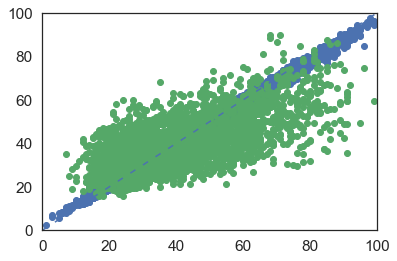

CV fold #4 (n_trees: 1023)
Root Mean Squared Error for training data: 1.738 / validation data: 11.654
Mean Absolute Error for training data: 1.318 / validation data: 8.871
Spearman's rank correlation coefficient for training data: 0.993 / validation data: 0.655


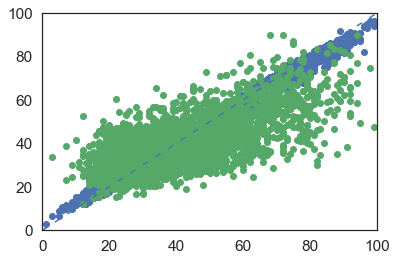

CV fold #5 (n_trees: 756)
Root Mean Squared Error for training data: 2.496 / validation data: 11.263
Mean Absolute Error for training data: 1.892 / validation data: 8.550
Spearman's rank correlation coefficient for training data: 0.986 / validation data: 0.639


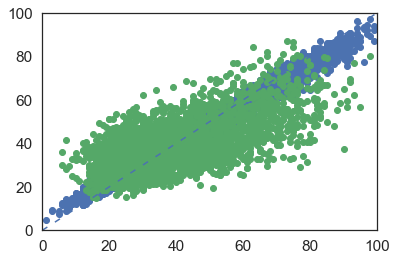

Cross-Validation resuls: (average n_trees: 992)
Root Mean Squared Error for training data: 1.959 +/- 0.535/ validation data: 11.548 +/- 0.150
Mean Absolute Error for training data: 1.490 +/- 0.403/ validation data: 8.735 +/- 0.125
Spearman's rank correlation coefficient for training data: 0.990 / validation data: 0.648



In [315]:
# Cross validation prediction with optimized hyperparameters
predictions_age = GridSearch_lgb_regressor(wiki_metadata[features], wiki_metadata["age"], param_grid_age, cv = 5, predict = True)

In [373]:
wiki_metadata["predicted_age_lgbm"] = predictions_age
wiki_metadata["error_age"] = wiki_metadata["predicted_age_lgbm"] - wiki_metadata["age"]
wiki_metadata["absolute_error_age"] = abs(wiki_metadata["error_age"])

In [110]:
# Same hyperparameters
param_grid_age = {}
param_grid_age["max_depth"] = [5]
param_grid_age["min_child_samples"] = [5]
param_grid_age["subsample"] = [1.0]
param_grid_age["subsample_freq"]=[1]
param_grid_age["colsample_bytree"]=[1.0]
param_grid_age["reg_alpha"] = [100]
param_grid_age["reg_lambda"] = [10]
param_grid_age["learning_rate"] = [0.1]
param_grid_age["random_state"]=[2]
param_grid_age["objective"]=["regression"]
param_grid_age["n_estimators"]=[840]


Hyperparameters:
max_depth : 5
min_child_samples : 5
subsample : 1.0
subsample_freq : 1
colsample_bytree : 1.0
reg_alpha : 100
reg_lambda : 10
learning_rate : 0.1
random_state : 2
objective : regression
n_estimators : 840
CV fold #1 (n_trees: 840)
Root Mean Squared Error for training data: 3.219 / validation data: 17.365
Mean Absolute Error for training data: 2.440 / validation data: 13.743
Spearman's rank correlation coefficient for training data: 0.989 / validation data: -0.029


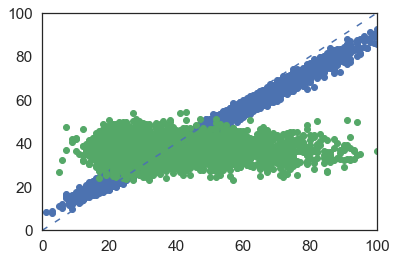

CV fold #2 (n_trees: 840)
Root Mean Squared Error for training data: 3.167 / validation data: 17.544
Mean Absolute Error for training data: 2.410 / validation data: 13.848
Spearman's rank correlation coefficient for training data: 0.989 / validation data: 0.004


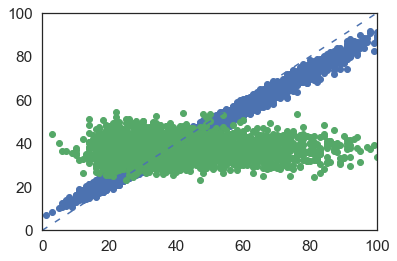

CV fold #3 (n_trees: 840)
Root Mean Squared Error for training data: 3.258 / validation data: 16.908
Mean Absolute Error for training data: 2.461 / validation data: 13.642
Spearman's rank correlation coefficient for training data: 0.990 / validation data: 0.016


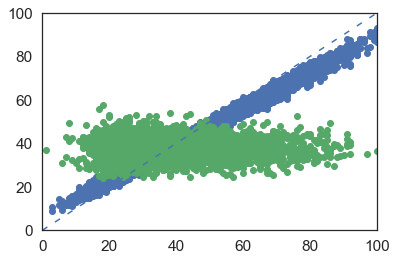

CV fold #4 (n_trees: 840)
Root Mean Squared Error for training data: 3.175 / validation data: 17.351
Mean Absolute Error for training data: 2.408 / validation data: 13.927
Spearman's rank correlation coefficient for training data: 0.990 / validation data: 0.001


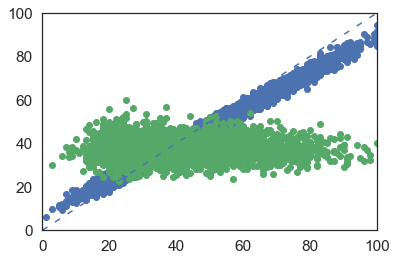

CV fold #5 (n_trees: 840)
Root Mean Squared Error for training data: 3.167 / validation data: 18.834
Mean Absolute Error for training data: 2.448 / validation data: 13.930
Spearman's rank correlation coefficient for training data: 0.990 / validation data: -0.013


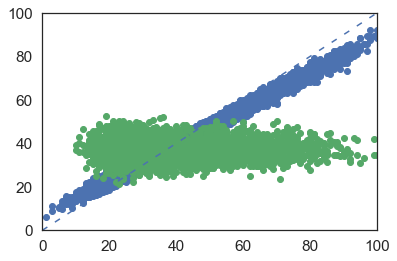

Cross-Validation resuls: (average n_trees: 840)
Root Mean Squared Error for training data: 3.197 +/- 0.036/ validation data: 17.600 +/- 0.651
Mean Absolute Error for training data: 2.433 +/- 0.021/ validation data: 13.818 +/- 0.111
Spearman's rank correlation coefficient for training data: 0.990 / validation data: -0.004


In [111]:
# Cross validation prediction for random age
GridSearch_lgb_regressor(bottlenecks[features], bottlenecks["age"].sample(frac=1).reset_index(drop=True), param_grid_age, cv = 5, predict = False, early_stopping = False)

max_depth 2
min_child_samples 5
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 7.636 / RMSE for validation data: 13.831 (n_trees: 1046)


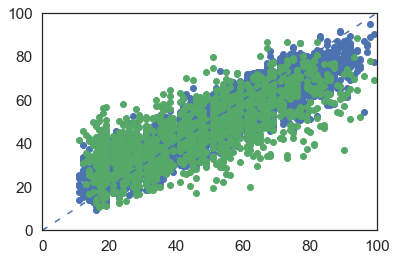

CV 2 : RMSE for training data: 9.107 / RMSE for validation data: 13.856 (n_trees: 703)


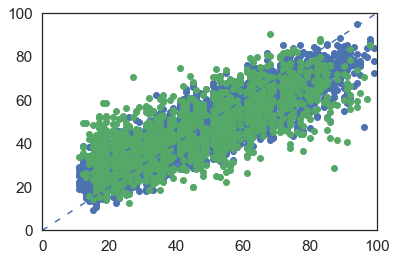

CV 3 : RMSE for training data: 8.918 / RMSE for validation data: 14.442 (n_trees: 706)


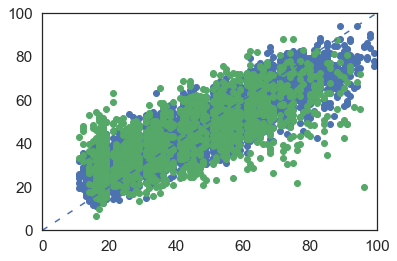

CV 4 : RMSE for training data: 8.429 / RMSE for validation data: 13.888 (n_trees: 824)


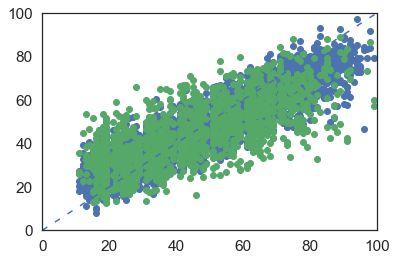

CV 5 : RMSE for training data: 9.944 / RMSE for validation data: 14.505 (n_trees: 506)


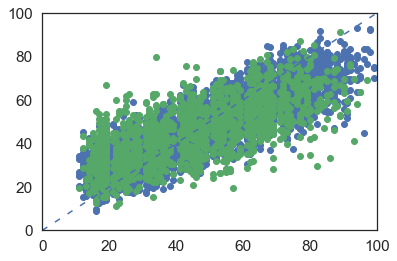

Cross-Validation RMSE: 14.104 +/- 0.605 (n_trees: 757)
Training data RMSE: 8.807 +/- 1.526 (n_trees: 757)
max_depth 2
min_child_samples 10
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 8.281 / RMSE for validation data: 13.844 (n_trees: 883)


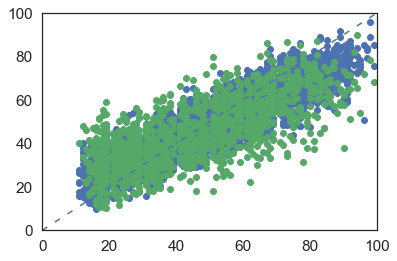

CV 2 : RMSE for training data: 8.854 / RMSE for validation data: 13.853 (n_trees: 757)


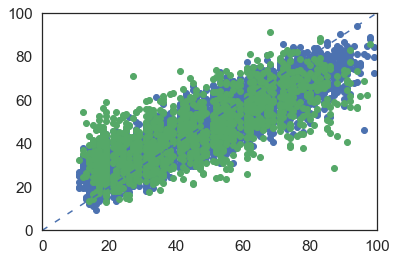

CV 3 : RMSE for training data: 9.816 / RMSE for validation data: 14.495 (n_trees: 534)


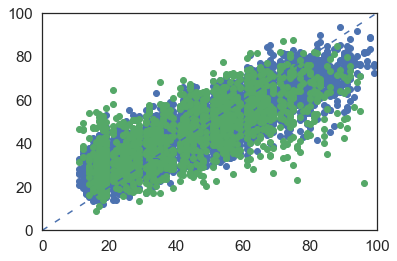

CV 4 : RMSE for training data: 8.142 / RMSE for validation data: 13.896 (n_trees: 893)


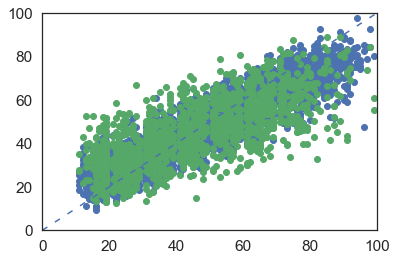

CV 5 : RMSE for training data: 10.404 / RMSE for validation data: 14.464 (n_trees: 430)


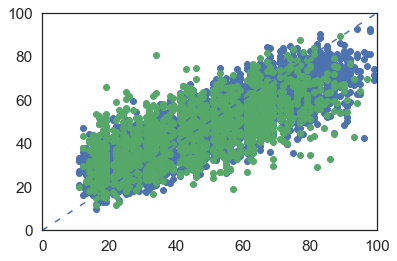

Cross-Validation RMSE: 14.110 +/- 0.604 (n_trees: 699)
Training data RMSE: 9.100 +/- 1.758 (n_trees: 699)
max_depth 2
min_child_samples 50
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 8.239 / RMSE for validation data: 13.841 (n_trees: 906)


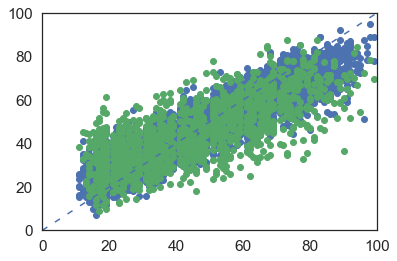

CV 2 : RMSE for training data: 9.207 / RMSE for validation data: 13.833 (n_trees: 703)


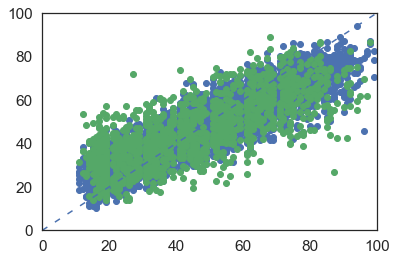

CV 3 : RMSE for training data: 7.070 / RMSE for validation data: 14.424 (n_trees: 1190)


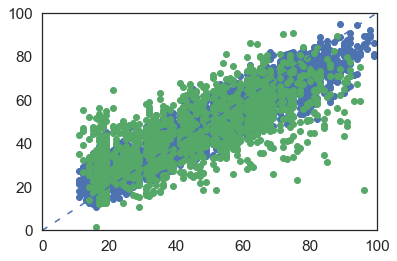

CV 4 : RMSE for training data: 7.349 / RMSE for validation data: 13.891 (n_trees: 1120)


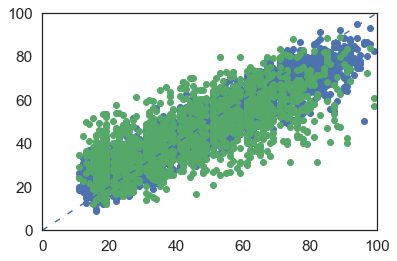

CV 5 : RMSE for training data: 10.053 / RMSE for validation data: 14.451 (n_trees: 497)


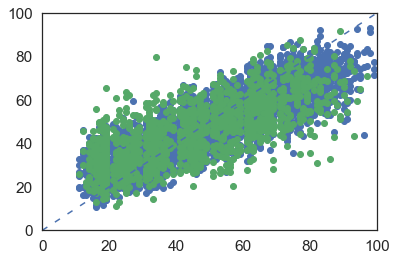

Cross-Validation RMSE: 14.088 +/- 0.572 (n_trees: 883)
Training data RMSE: 8.384 +/- 2.242 (n_trees: 883)
max_depth 2
min_child_samples 100
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 9.658 / RMSE for validation data: 13.907 (n_trees: 634)


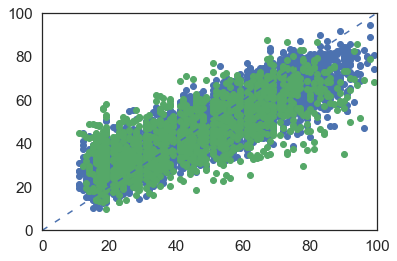

CV 2 : RMSE for training data: 8.286 / RMSE for validation data: 13.820 (n_trees: 957)


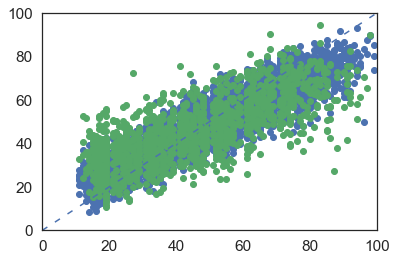

CV 3 : RMSE for training data: 9.122 / RMSE for validation data: 14.452 (n_trees: 710)


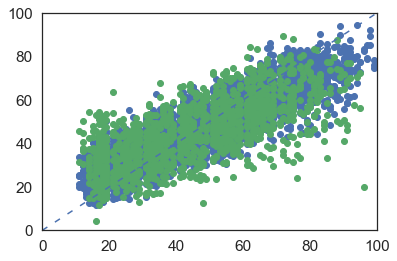

CV 4 : RMSE for training data: 8.815 / RMSE for validation data: 13.958 (n_trees: 779)


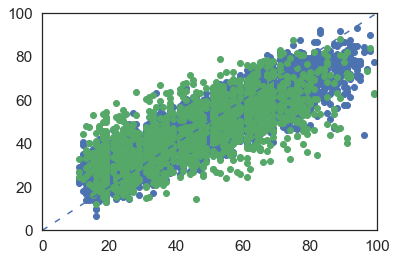

CV 5 : RMSE for training data: 10.848 / RMSE for validation data: 14.459 (n_trees: 380)


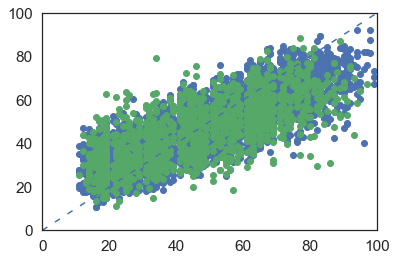

Cross-Validation RMSE: 14.119 +/- 0.556 (n_trees: 692)
Training data RMSE: 9.346 +/- 1.746 (n_trees: 692)
max_depth 2
min_child_samples 150
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 7.304 / RMSE for validation data: 13.824 (n_trees: 1263)


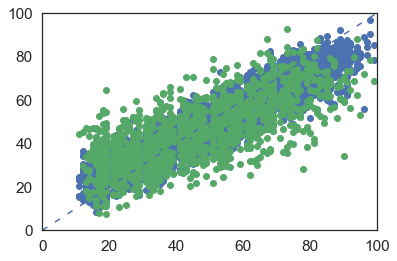

CV 2 : RMSE for training data: 9.056 / RMSE for validation data: 13.818 (n_trees: 788)


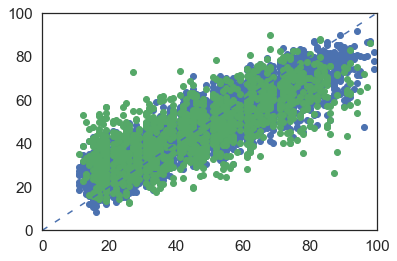

CV 3 : RMSE for training data: 7.894 / RMSE for validation data: 14.485 (n_trees: 1041)


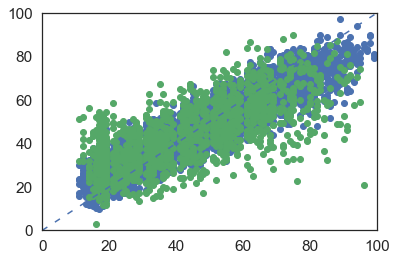

CV 4 : RMSE for training data: 9.072 / RMSE for validation data: 13.874 (n_trees: 755)


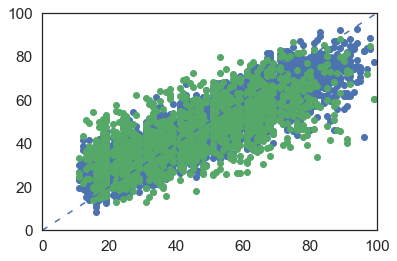

CV 5 : RMSE for training data: 10.600 / RMSE for validation data: 14.410 (n_trees: 432)


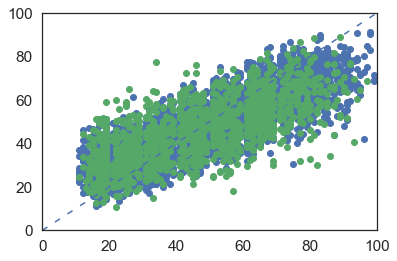

Cross-Validation RMSE: 14.082 +/- 0.600 (n_trees: 856)
Training data RMSE: 8.785 +/- 2.270 (n_trees: 856)
max_depth 2
min_child_samples 200
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 9.682 / RMSE for validation data: 13.963 (n_trees: 682)


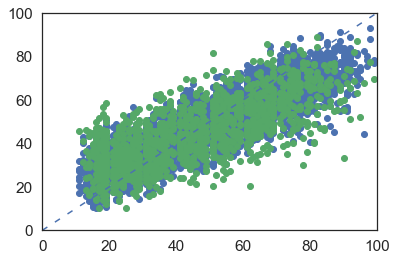

CV 2 : RMSE for training data: 9.370 / RMSE for validation data: 13.793 (n_trees: 732)


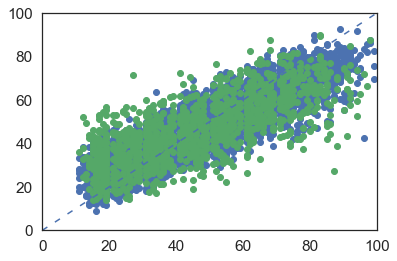

CV 3 : RMSE for training data: 10.385 / RMSE for validation data: 14.524 (n_trees: 482)


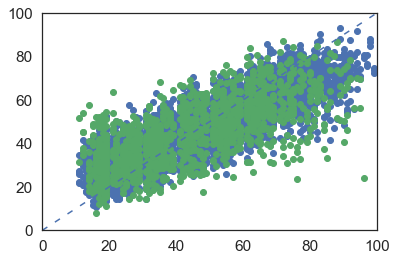

CV 4 : RMSE for training data: 8.566 / RMSE for validation data: 13.904 (n_trees: 920)


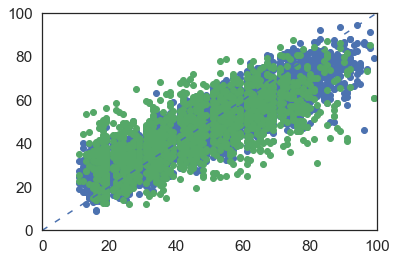

CV 5 : RMSE for training data: 10.058 / RMSE for validation data: 14.438 (n_trees: 539)


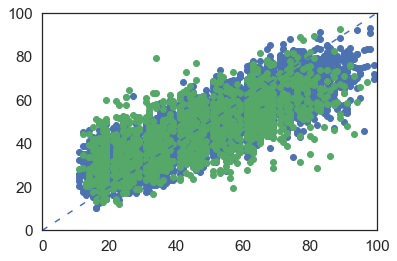

Cross-Validation RMSE: 14.124 +/- 0.595 (n_trees: 671)
Training data RMSE: 9.612 +/- 1.250 (n_trees: 671)
max_depth 3
min_child_samples 5
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 5.659 / RMSE for validation data: 13.739 (n_trees: 593)


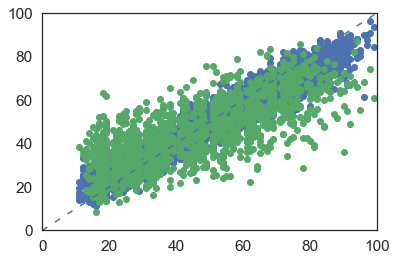

CV 2 : RMSE for training data: 7.825 / RMSE for validation data: 13.912 (n_trees: 357)


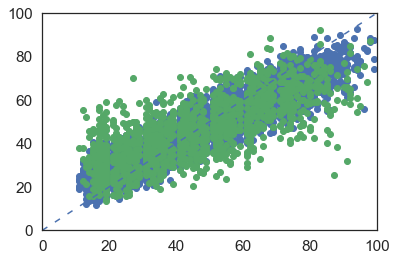

CV 3 : RMSE for training data: 7.847 / RMSE for validation data: 14.456 (n_trees: 347)


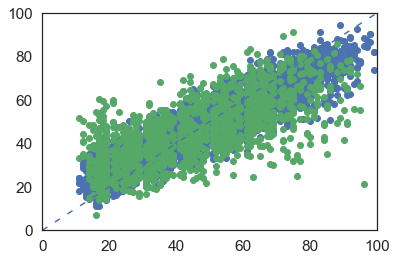

CV 4 : RMSE for training data: 6.959 / RMSE for validation data: 13.944 (n_trees: 436)


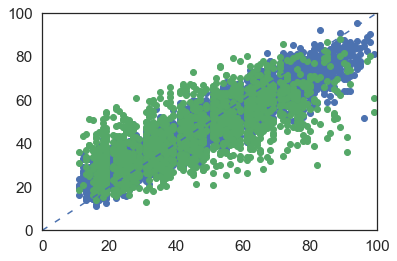

CV 5 : RMSE for training data: 7.794 / RMSE for validation data: 14.399 (n_trees: 344)


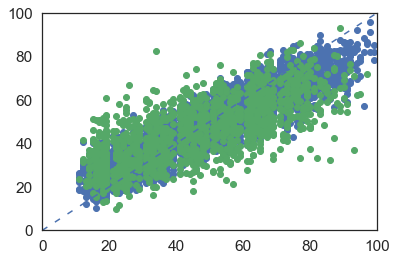

Cross-Validation RMSE: 14.090 +/- 0.569 (n_trees: 415)
Training data RMSE: 7.217 +/- 1.695 (n_trees: 415)
max_depth 3
min_child_samples 10
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 4.913 / RMSE for validation data: 13.766 (n_trees: 708)


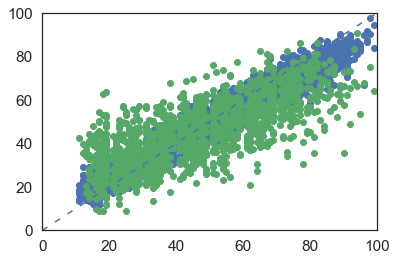

CV 2 : RMSE for training data: 7.858 / RMSE for validation data: 13.868 (n_trees: 359)


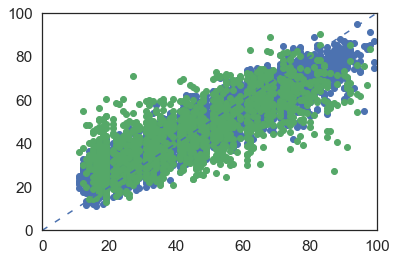

CV 3 : RMSE for training data: 6.152 / RMSE for validation data: 14.362 (n_trees: 522)


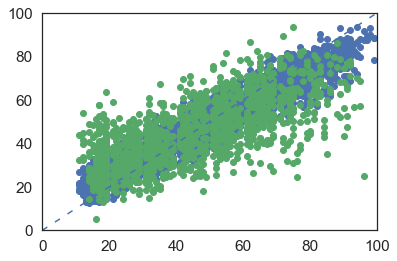

CV 4 : RMSE for training data: 4.444 / RMSE for validation data: 13.875 (n_trees: 771)


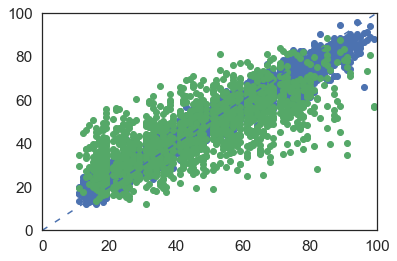

CV 5 : RMSE for training data: 8.522 / RMSE for validation data: 14.417 (n_trees: 287)


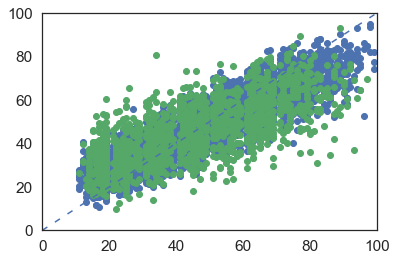

Cross-Validation RMSE: 14.057 +/- 0.548 (n_trees: 529)
Training data RMSE: 6.378 +/- 3.190 (n_trees: 529)
max_depth 3
min_child_samples 50
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 5.993 / RMSE for validation data: 13.781 (n_trees: 592)


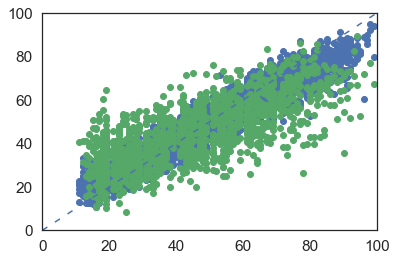

CV 2 : RMSE for training data: 7.653 / RMSE for validation data: 13.863 (n_trees: 399)


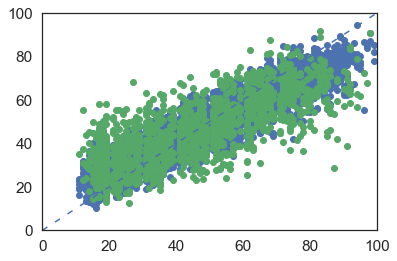

CV 3 : RMSE for training data: 6.375 / RMSE for validation data: 14.444 (n_trees: 529)


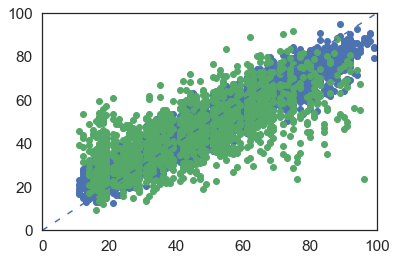

CV 4 : RMSE for training data: 4.472 / RMSE for validation data: 13.928 (n_trees: 813)


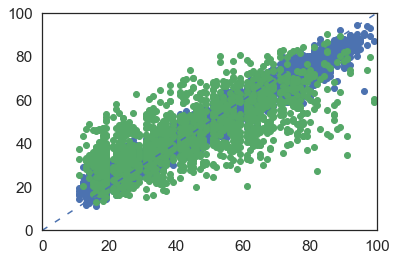

CV 5 : RMSE for training data: 9.287 / RMSE for validation data: 14.400 (n_trees: 242)


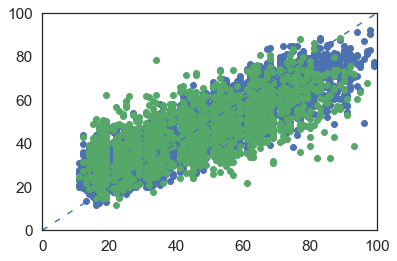

Cross-Validation RMSE: 14.083 +/- 0.561 (n_trees: 515)
Training data RMSE: 6.756 +/- 3.244 (n_trees: 515)
max_depth 3
min_child_samples 100
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 5.666 / RMSE for validation data: 13.751 (n_trees: 710)


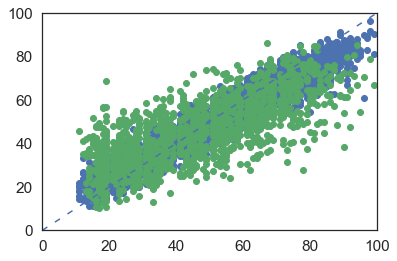

CV 2 : RMSE for training data: 4.466 / RMSE for validation data: 13.635 (n_trees: 908)


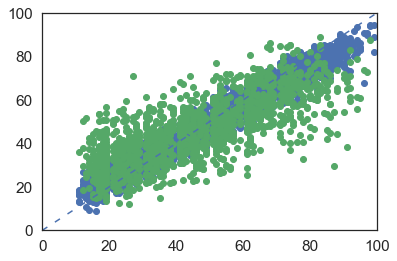

CV 3 : RMSE for training data: 6.302 / RMSE for validation data: 14.367 (n_trees: 594)


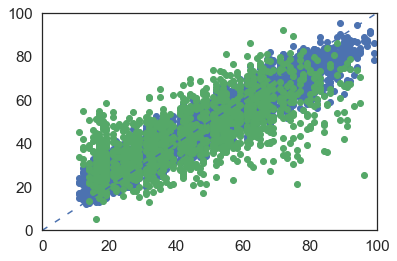

CV 4 : RMSE for training data: 8.810 / RMSE for validation data: 13.971 (n_trees: 314)


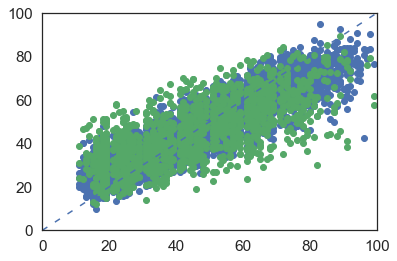

CV 5 : RMSE for training data: 6.983 / RMSE for validation data: 14.379 (n_trees: 493)


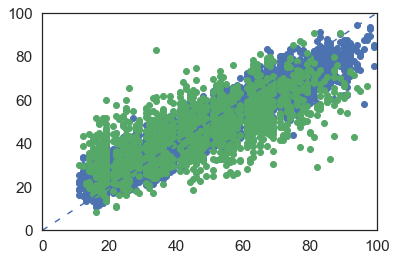

Cross-Validation RMSE: 14.020 +/- 0.614 (n_trees: 604)
Training data RMSE: 6.445 +/- 2.888 (n_trees: 604)
max_depth 3
min_child_samples 150
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 4.572 / RMSE for validation data: 13.740 (n_trees: 983)


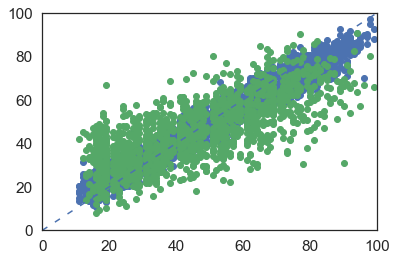

CV 2 : RMSE for training data: 6.938 / RMSE for validation data: 13.751 (n_trees: 569)


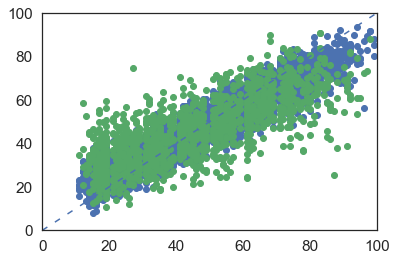

CV 3 : RMSE for training data: 7.114 / RMSE for validation data: 14.450 (n_trees: 524)


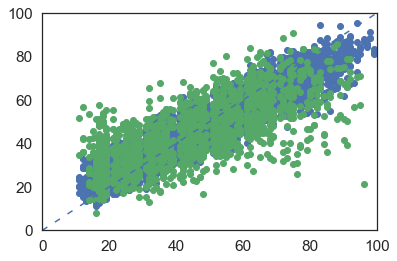

CV 4 : RMSE for training data: 5.313 / RMSE for validation data: 13.904 (n_trees: 801)


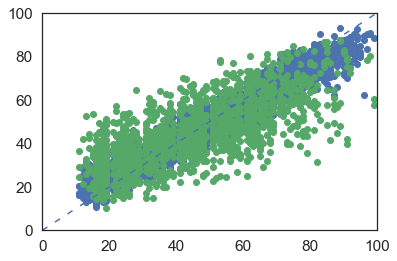

CV 5 : RMSE for training data: 8.498 / RMSE for validation data: 14.389 (n_trees: 357)


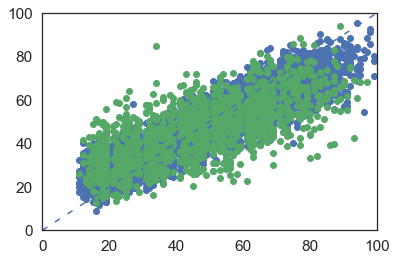

Cross-Validation RMSE: 14.046 +/- 0.621 (n_trees: 647)
Training data RMSE: 6.487 +/- 2.783 (n_trees: 647)
max_depth 3
min_child_samples 200
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 6.400 / RMSE for validation data: 13.795 (n_trees: 692)


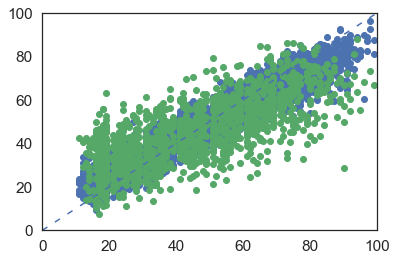

CV 2 : RMSE for training data: 6.729 / RMSE for validation data: 13.691 (n_trees: 650)


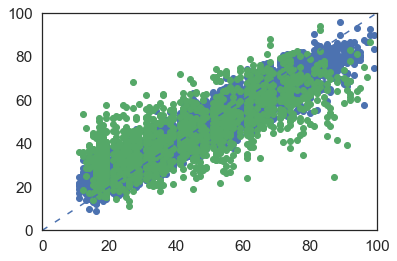

CV 3 : RMSE for training data: 8.144 / RMSE for validation data: 14.459 (n_trees: 438)


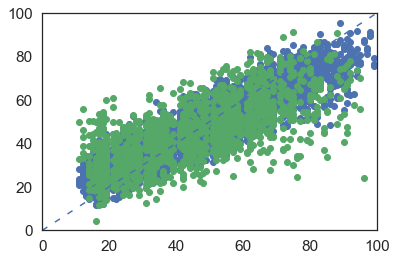

CV 4 : RMSE for training data: 5.463 / RMSE for validation data: 13.820 (n_trees: 855)


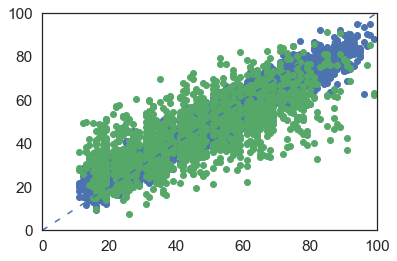

CV 5 : RMSE for training data: 7.332 / RMSE for validation data: 14.414 (n_trees: 516)


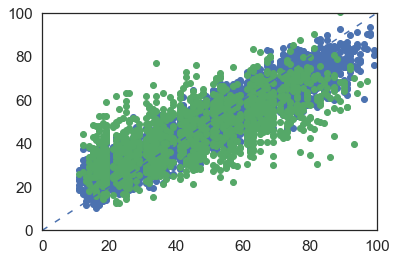

Cross-Validation RMSE: 14.036 +/- 0.661 (n_trees: 630)
Training data RMSE: 6.813 +/- 1.798 (n_trees: 630)
max_depth 4
min_child_samples 5
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 2.312 / RMSE for validation data: 13.831 (n_trees: 586)


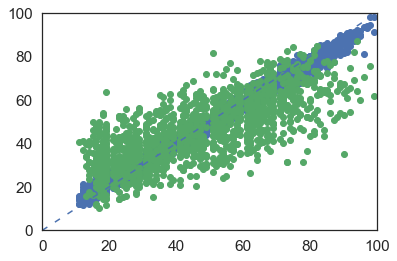

CV 2 : RMSE for training data: 5.252 / RMSE for validation data: 13.966 (n_trees: 300)


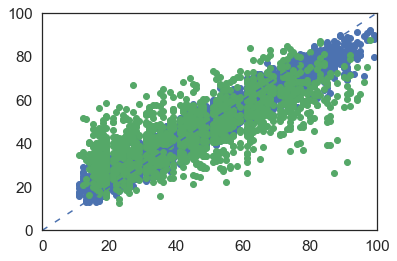

CV 3 : RMSE for training data: 0.520 / RMSE for validation data: 14.392 (n_trees: 1152)


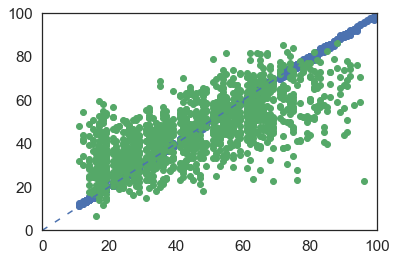

CV 4 : RMSE for training data: 0.508 / RMSE for validation data: 13.785 (n_trees: 1163)


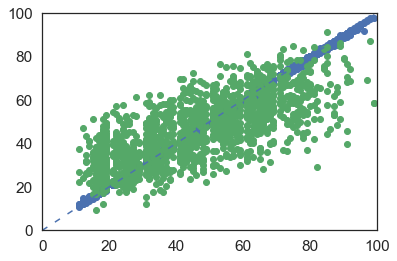

CV 5 : RMSE for training data: 4.158 / RMSE for validation data: 14.271 (n_trees: 368)


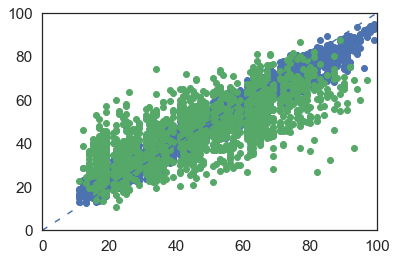

Cross-Validation RMSE: 14.049 +/- 0.483 (n_trees: 714)
Training data RMSE: 2.550 +/- 3.819 (n_trees: 714)
max_depth 4
min_child_samples 10
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 5.338 / RMSE for validation data: 13.887 (n_trees: 296)


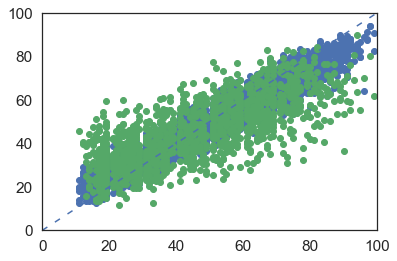

CV 2 : RMSE for training data: 3.862 / RMSE for validation data: 13.949 (n_trees: 411)


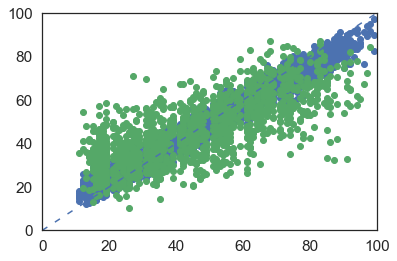

CV 3 : RMSE for training data: 5.902 / RMSE for validation data: 14.418 (n_trees: 264)


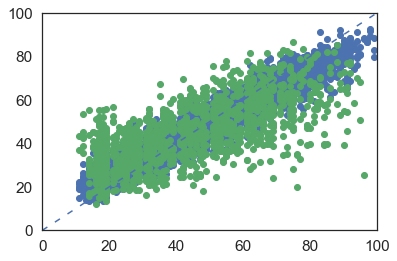

CV 4 : RMSE for training data: 2.776 / RMSE for validation data: 13.951 (n_trees: 519)


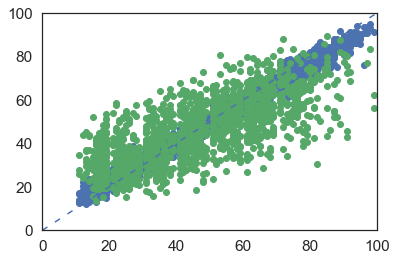

CV 5 : RMSE for training data: 5.264 / RMSE for validation data: 14.376 (n_trees: 288)


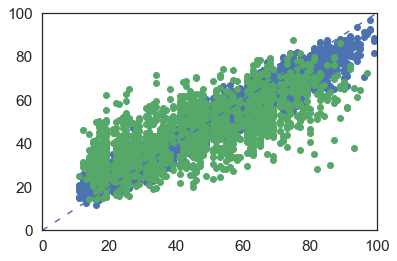

Cross-Validation RMSE: 14.116 +/- 0.462 (n_trees: 356)
Training data RMSE: 4.629 +/- 2.289 (n_trees: 356)
max_depth 4
min_child_samples 50
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 1.352 / RMSE for validation data: 13.810 (n_trees: 888)


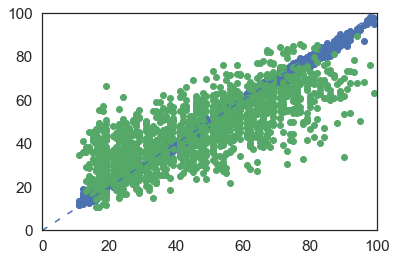

CV 2 : RMSE for training data: 7.956 / RMSE for validation data: 13.988 (n_trees: 185)


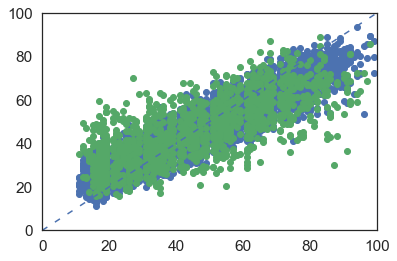

CV 3 : RMSE for training data: 3.730 / RMSE for validation data: 14.384 (n_trees: 469)


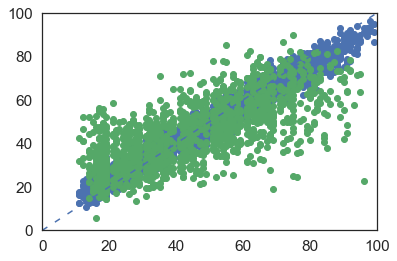

CV 4 : RMSE for training data: 1.751 / RMSE for validation data: 13.955 (n_trees: 761)


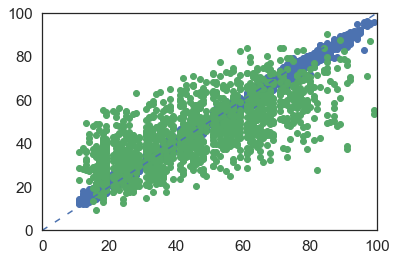

CV 5 : RMSE for training data: 7.028 / RMSE for validation data: 14.336 (n_trees: 221)


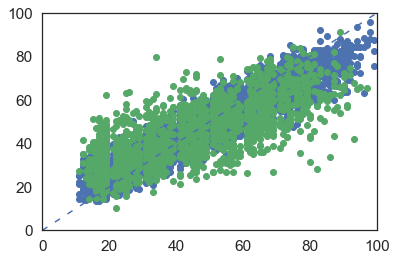

Cross-Validation RMSE: 14.095 +/- 0.451 (n_trees: 505)
Training data RMSE: 4.363 +/- 5.389 (n_trees: 505)
max_depth 4
min_child_samples 100
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 5.552 / RMSE for validation data: 13.794 (n_trees: 377)


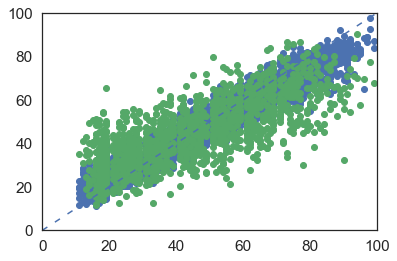

CV 2 : RMSE for training data: 6.956 / RMSE for validation data: 13.874 (n_trees: 280)


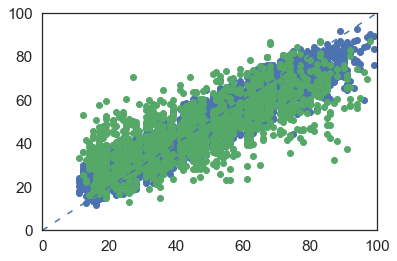

CV 3 : RMSE for training data: 5.181 / RMSE for validation data: 14.446 (n_trees: 403)


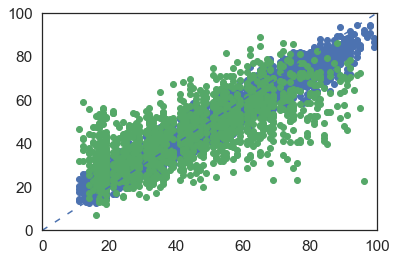

CV 4 : RMSE for training data: 4.062 / RMSE for validation data: 13.880 (n_trees: 514)


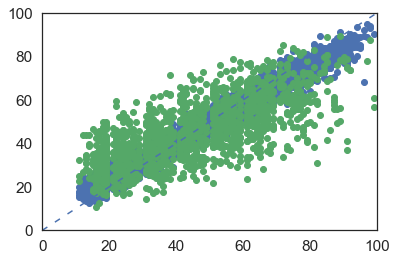

CV 5 : RMSE for training data: 4.670 / RMSE for validation data: 14.429 (n_trees: 449)


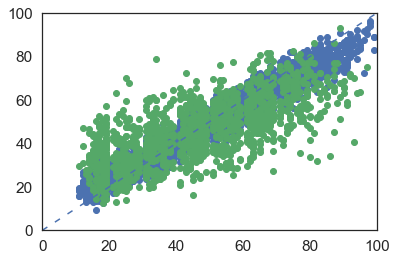

Cross-Validation RMSE: 14.085 +/- 0.580 (n_trees: 405)
Training data RMSE: 5.284 +/- 1.949 (n_trees: 405)
max_depth 4
min_child_samples 150
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 5.559 / RMSE for validation data: 13.872 (n_trees: 439)


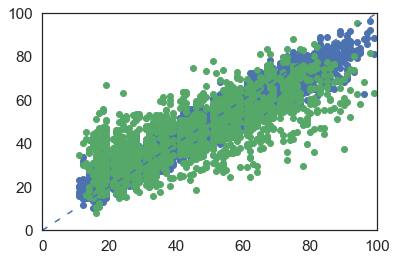

CV 2 : RMSE for training data: 4.346 / RMSE for validation data: 13.816 (n_trees: 562)


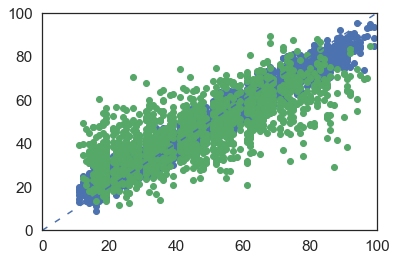

CV 3 : RMSE for training data: 4.424 / RMSE for validation data: 14.204 (n_trees: 562)


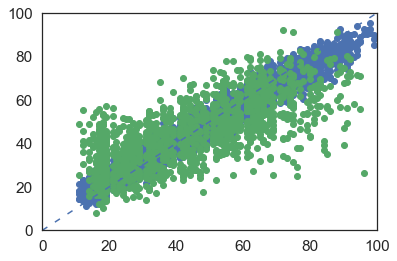

CV 4 : RMSE for training data: 3.495 / RMSE for validation data: 13.860 (n_trees: 683)


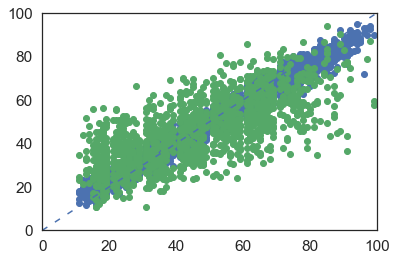

CV 5 : RMSE for training data: 6.487 / RMSE for validation data: 14.489 (n_trees: 326)


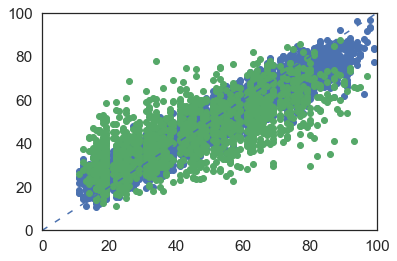

Cross-Validation RMSE: 14.048 +/- 0.520 (n_trees: 514)
Training data RMSE: 4.862 +/- 2.089 (n_trees: 514)
max_depth 4
min_child_samples 200
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 6.878 / RMSE for validation data: 13.798 (n_trees: 351)


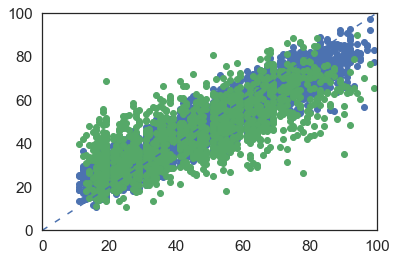

CV 2 : RMSE for training data: 4.234 / RMSE for validation data: 13.733 (n_trees: 667)


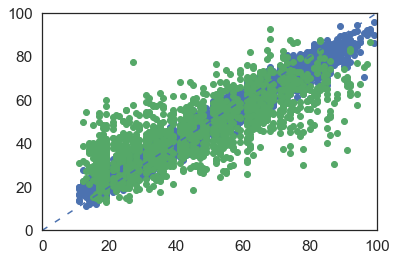

CV 3 : RMSE for training data: 7.038 / RMSE for validation data: 14.429 (n_trees: 341)


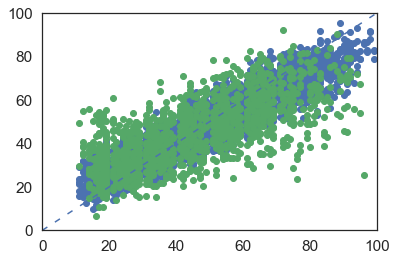

CV 4 : RMSE for training data: 5.797 / RMSE for validation data: 13.888 (n_trees: 462)


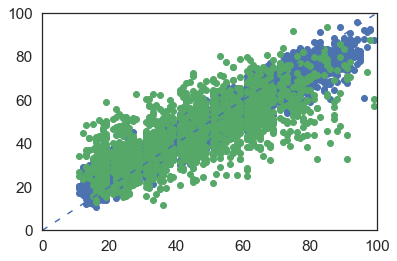

CV 5 : RMSE for training data: 5.630 / RMSE for validation data: 14.380 (n_trees: 460)


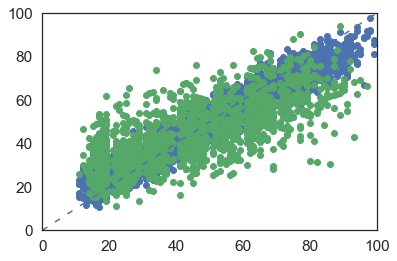

Cross-Validation RMSE: 14.046 +/- 0.595 (n_trees: 456)
Training data RMSE: 5.915 +/- 2.021 (n_trees: 456)
max_depth 5
min_child_samples 5
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 0.625 / RMSE for validation data: 13.848 (n_trees: 563)


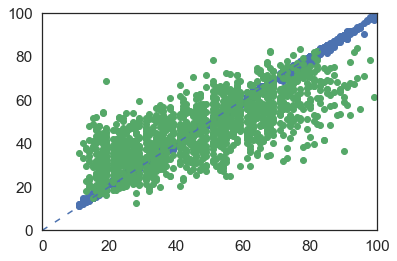

CV 2 : RMSE for training data: 0.668 / RMSE for validation data: 14.062 (n_trees: 562)


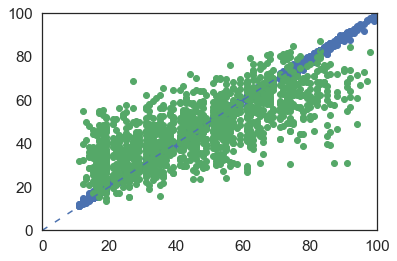

CV 3 : RMSE for training data: 1.403 / RMSE for validation data: 14.484 (n_trees: 407)


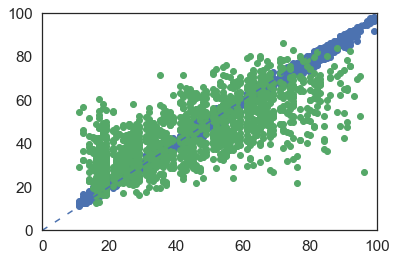

CV 4 : RMSE for training data: 0.173 / RMSE for validation data: 14.065 (n_trees: 1028)


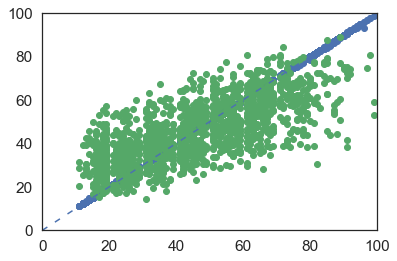

CV 5 : RMSE for training data: 0.223 / RMSE for validation data: 14.294 (n_trees: 863)


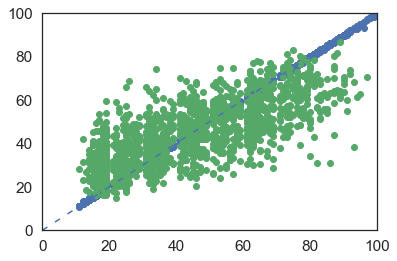

Cross-Validation RMSE: 14.151 +/- 0.437 (n_trees: 685)
Training data RMSE: 0.618 +/- 0.882 (n_trees: 685)
max_depth 5
min_child_samples 10
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 0.860 / RMSE for validation data: 13.803 (n_trees: 506)


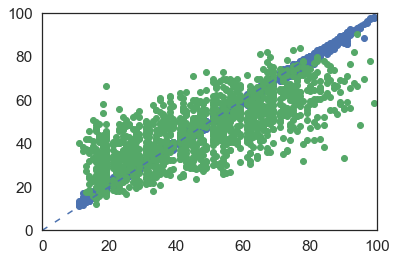

CV 2 : RMSE for training data: 1.027 / RMSE for validation data: 13.943 (n_trees: 480)


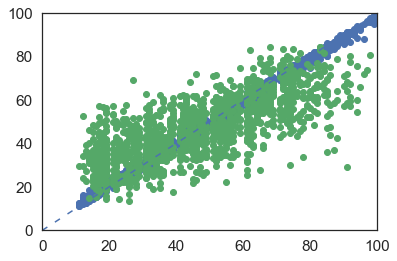

CV 3 : RMSE for training data: 0.936 / RMSE for validation data: 14.406 (n_trees: 494)


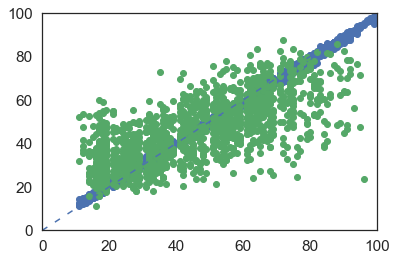

CV 4 : RMSE for training data: 1.431 / RMSE for validation data: 14.062 (n_trees: 411)


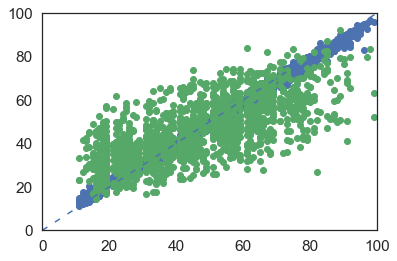

CV 5 : RMSE for training data: 2.216 / RMSE for validation data: 14.403 (n_trees: 318)


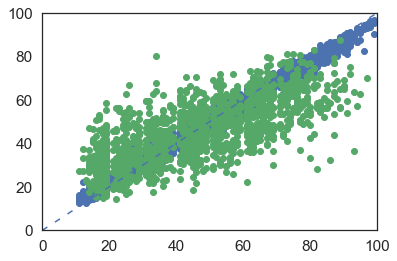

Cross-Validation RMSE: 14.123 +/- 0.487 (n_trees: 442)
Training data RMSE: 1.294 +/- 1.003 (n_trees: 442)
max_depth 5
min_child_samples 50
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 0.505 / RMSE for validation data: 13.745 (n_trees: 743)


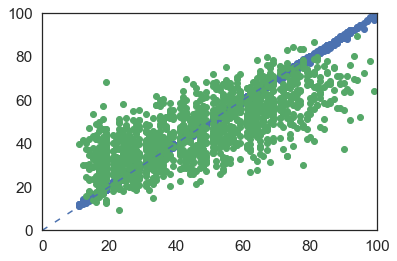

CV 2 : RMSE for training data: 0.184 / RMSE for validation data: 13.938 (n_trees: 1109)


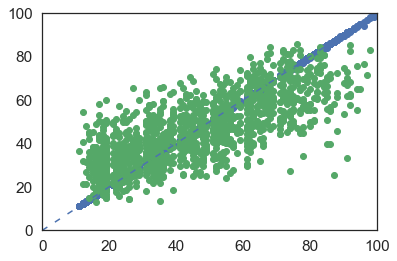

CV 3 : RMSE for training data: 2.425 / RMSE for validation data: 14.374 (n_trees: 371)


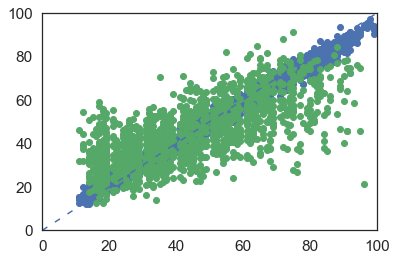

CV 4 : RMSE for training data: 0.890 / RMSE for validation data: 13.910 (n_trees: 613)


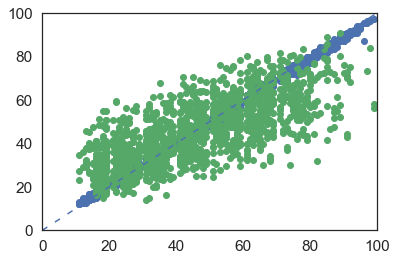

CV 5 : RMSE for training data: 3.427 / RMSE for validation data: 14.426 (n_trees: 286)


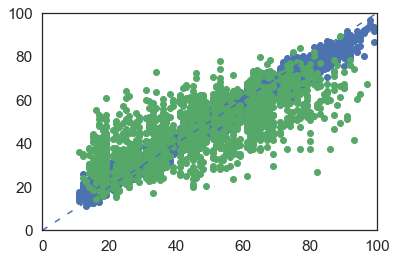

Cross-Validation RMSE: 14.079 +/- 0.542 (n_trees: 624)
Training data RMSE: 1.486 +/- 2.475 (n_trees: 624)
max_depth 5
min_child_samples 100
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 1.633 / RMSE for validation data: 13.835 (n_trees: 604)


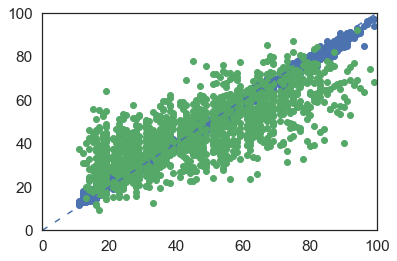

CV 2 : RMSE for training data: 2.940 / RMSE for validation data: 13.911 (n_trees: 451)


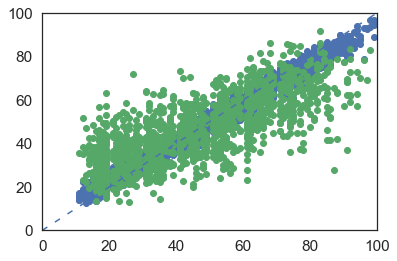

CV 3 : RMSE for training data: 6.489 / RMSE for validation data: 14.407 (n_trees: 185)


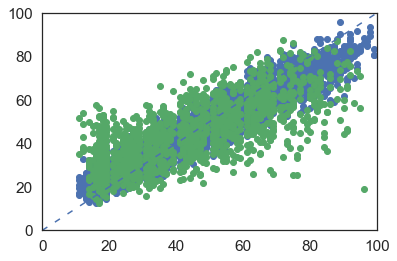

CV 4 : RMSE for training data: 6.060 / RMSE for validation data: 14.006 (n_trees: 209)


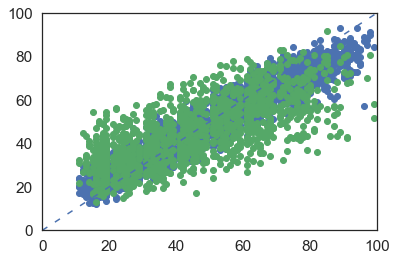

CV 5 : RMSE for training data: 2.275 / RMSE for validation data: 14.341 (n_trees: 503)


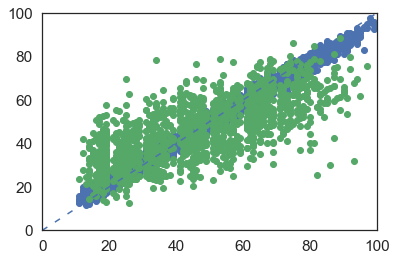

Cross-Validation RMSE: 14.100 +/- 0.463 (n_trees: 390)
Training data RMSE: 3.879 +/- 4.007 (n_trees: 390)
max_depth 5
min_child_samples 150
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 3.860 / RMSE for validation data: 13.795 (n_trees: 427)


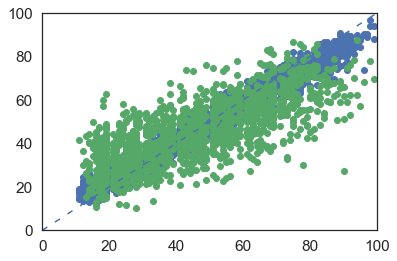

CV 2 : RMSE for training data: 4.011 / RMSE for validation data: 13.748 (n_trees: 406)


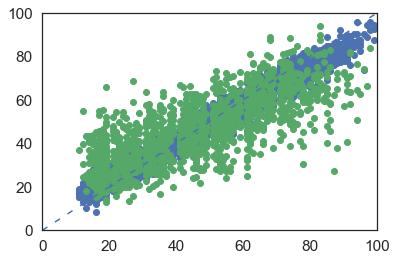

CV 3 : RMSE for training data: 6.165 / RMSE for validation data: 14.420 (n_trees: 248)


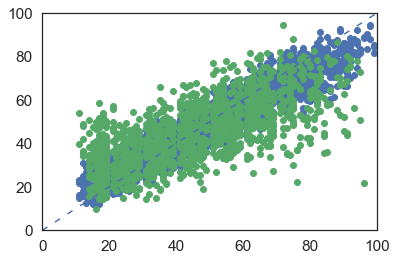

CV 4 : RMSE for training data: 2.903 / RMSE for validation data: 13.895 (n_trees: 535)


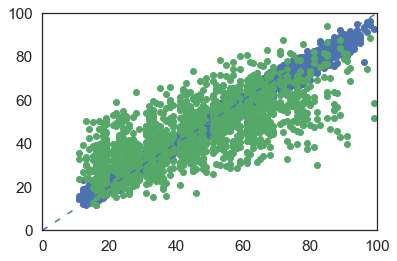

CV 5 : RMSE for training data: 6.882 / RMSE for validation data: 14.294 (n_trees: 198)


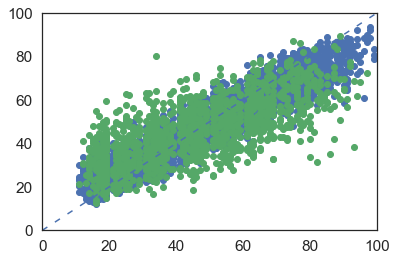

Cross-Validation RMSE: 14.031 +/- 0.547 (n_trees: 363)
Training data RMSE: 4.764 +/- 3.006 (n_trees: 363)
max_depth 5
min_child_samples 200
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 6.350 / RMSE for validation data: 13.999 (n_trees: 283)


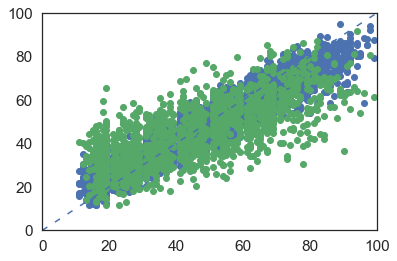

CV 2 : RMSE for training data: 5.186 / RMSE for validation data: 13.864 (n_trees: 374)


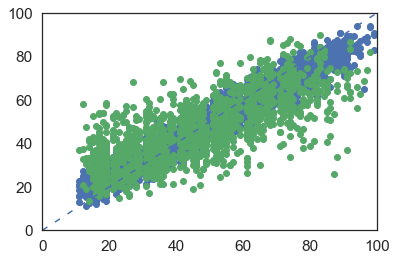

CV 3 : RMSE for training data: 4.102 / RMSE for validation data: 14.280 (n_trees: 465)


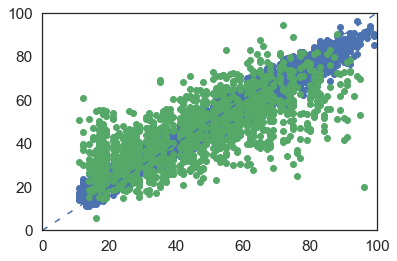

CV 4 : RMSE for training data: 7.495 / RMSE for validation data: 13.996 (n_trees: 222)


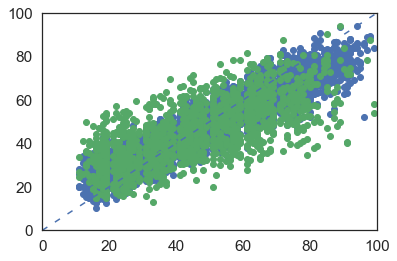

CV 5 : RMSE for training data: 4.429 / RMSE for validation data: 14.396 (n_trees: 406)


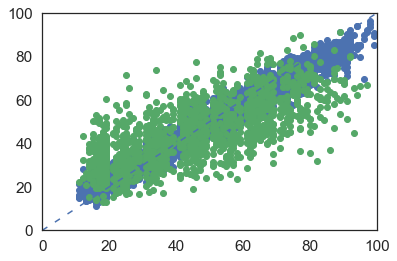

Cross-Validation RMSE: 14.107 +/- 0.397 (n_trees: 350)
Training data RMSE: 5.512 +/- 2.514 (n_trees: 350)
max_depth 6
min_child_samples 5
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 0.429 / RMSE for validation data: 14.028 (n_trees: 538)


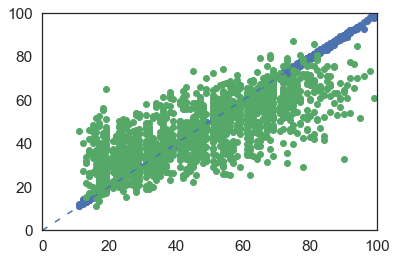

CV 2 : RMSE for training data: 0.174 / RMSE for validation data: 13.787 (n_trees: 813)


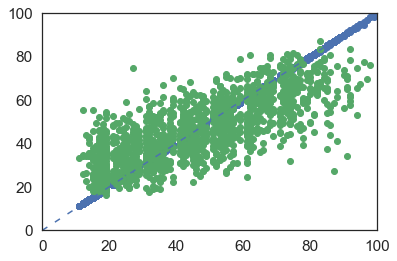

CV 3 : RMSE for training data: 0.360 / RMSE for validation data: 14.504 (n_trees: 578)


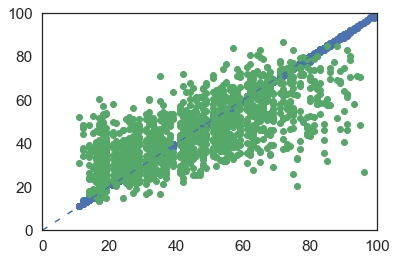

CV 4 : RMSE for training data: 2.271 / RMSE for validation data: 14.095 (n_trees: 256)


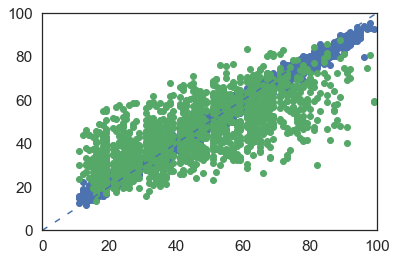

CV 5 : RMSE for training data: 0.167 / RMSE for validation data: 14.407 (n_trees: 832)


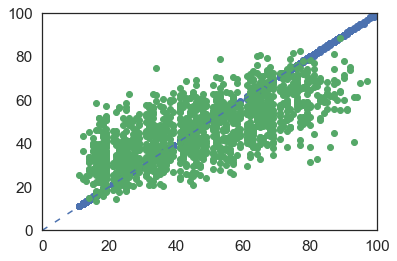

Cross-Validation RMSE: 14.164 +/- 0.522 (n_trees: 603)
Training data RMSE: 0.680 +/- 1.604 (n_trees: 603)
max_depth 6
min_child_samples 10
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 0.546 / RMSE for validation data: 13.882 (n_trees: 497)


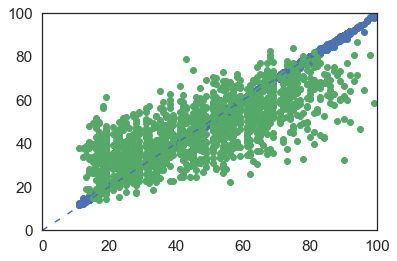

CV 2 : RMSE for training data: 0.172 / RMSE for validation data: 13.895 (n_trees: 828)


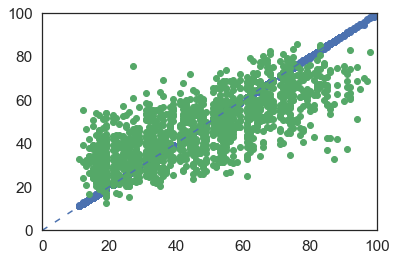

CV 3 : RMSE for training data: 1.373 / RMSE for validation data: 14.493 (n_trees: 334)


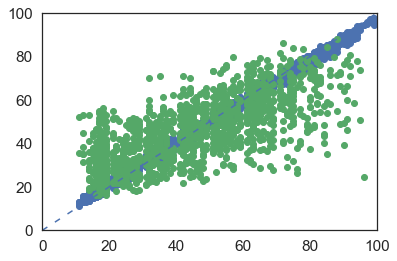

CV 4 : RMSE for training data: 0.166 / RMSE for validation data: 13.844 (n_trees: 855)


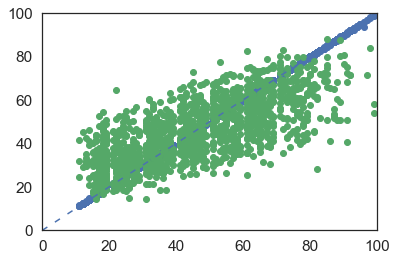

CV 5 : RMSE for training data: 1.341 / RMSE for validation data: 14.561 (n_trees: 331)


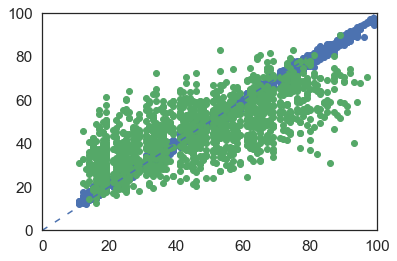

Cross-Validation RMSE: 14.135 +/- 0.643 (n_trees: 569)
Training data RMSE: 0.719 +/- 1.076 (n_trees: 569)
max_depth 6
min_child_samples 50
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 1.076 / RMSE for validation data: 13.974 (n_trees: 421)


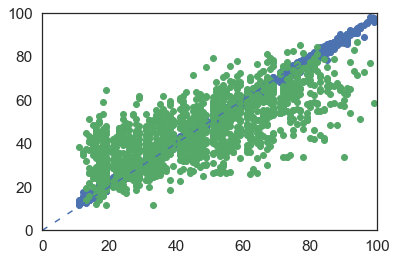

CV 2 : RMSE for training data: 5.338 / RMSE for validation data: 13.950 (n_trees: 145)


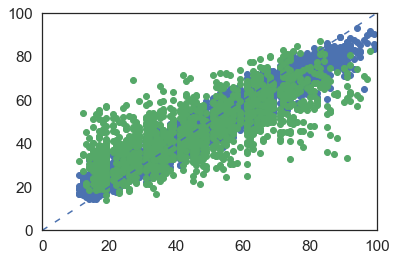

CV 3 : RMSE for training data: 2.619 / RMSE for validation data: 14.334 (n_trees: 262)


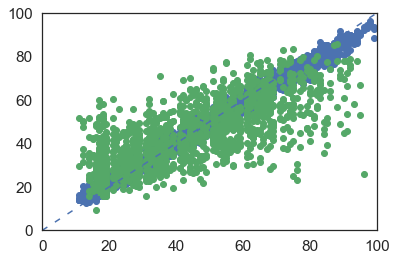

CV 4 : RMSE for training data: 0.253 / RMSE for validation data: 13.876 (n_trees: 725)


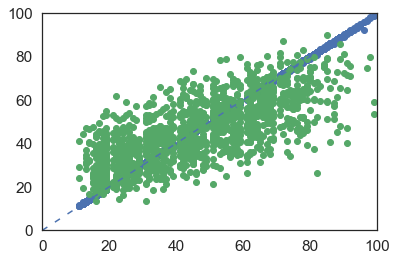

CV 5 : RMSE for training data: 3.087 / RMSE for validation data: 14.382 (n_trees: 226)


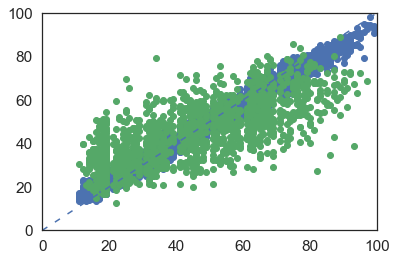

Cross-Validation RMSE: 14.103 +/- 0.422 (n_trees: 356)
Training data RMSE: 2.475 +/- 3.520 (n_trees: 356)
max_depth 6
min_child_samples 100
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 1.659 / RMSE for validation data: 13.694 (n_trees: 441)


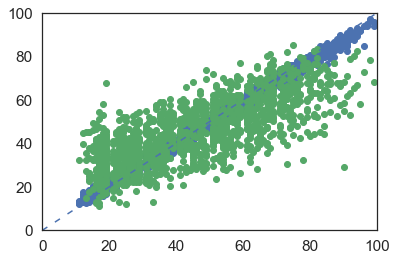

CV 2 : RMSE for training data: 0.677 / RMSE for validation data: 13.724 (n_trees: 625)


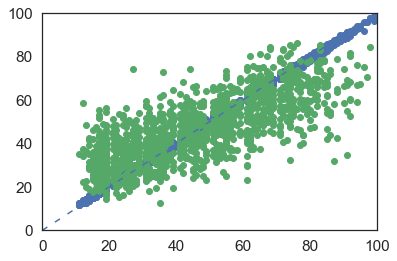

CV 3 : RMSE for training data: 0.958 / RMSE for validation data: 14.476 (n_trees: 565)


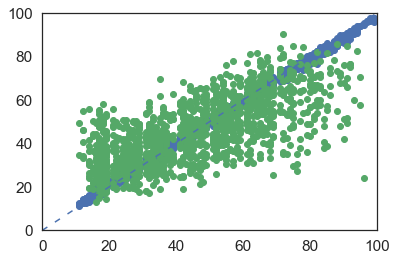

CV 4 : RMSE for training data: 2.118 / RMSE for validation data: 13.950 (n_trees: 388)


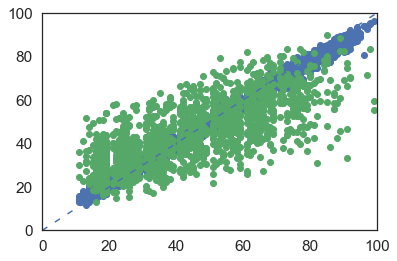

CV 5 : RMSE for training data: 0.894 / RMSE for validation data: 14.363 (n_trees: 563)


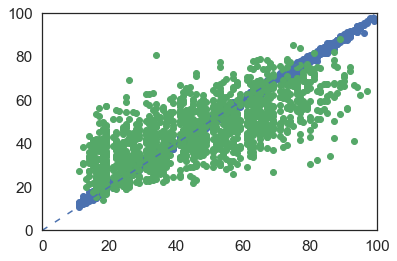

Cross-Validation RMSE: 14.041 +/- 0.646 (n_trees: 516)
Training data RMSE: 1.261 +/- 1.081 (n_trees: 516)
max_depth 6
min_child_samples 150
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 0.603 / RMSE for validation data: 13.732 (n_trees: 837)


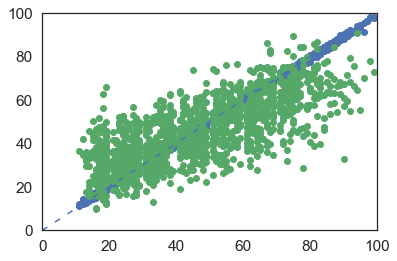

CV 2 : RMSE for training data: 0.753 / RMSE for validation data: 13.782 (n_trees: 805)


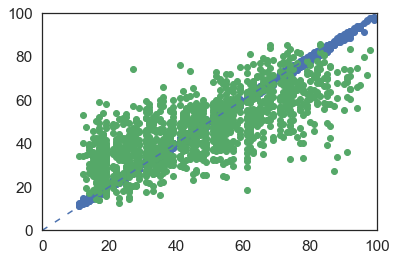

CV 3 : RMSE for training data: 5.959 / RMSE for validation data: 14.412 (n_trees: 205)


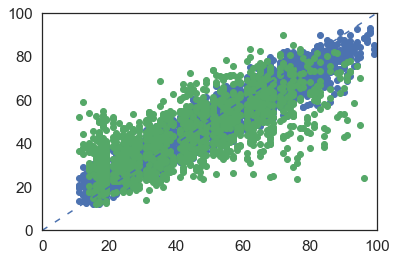

CV 4 : RMSE for training data: 1.037 / RMSE for validation data: 13.939 (n_trees: 676)


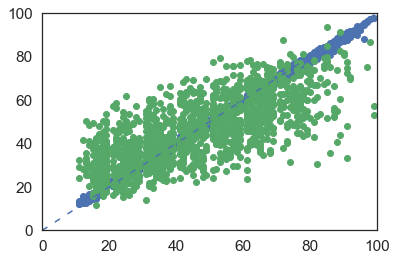

CV 5 : RMSE for training data: 2.068 / RMSE for validation data: 14.278 (n_trees: 501)


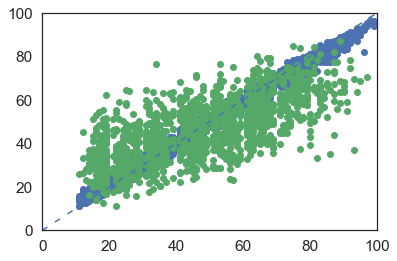

Cross-Validation RMSE: 14.028 +/- 0.541 (n_trees: 605)
Training data RMSE: 2.084 +/- 4.008 (n_trees: 605)
max_depth 6
min_child_samples 200
subsample 1.0
subsample_freq 1
colsample_bytree 1.0
reg_alpha 10
reg_lambda 10
learning_rate 0.1
random_state 2
objective regression
n_estimators 50000
CV 1 : RMSE for training data: 4.366 / RMSE for validation data: 13.843 (n_trees: 353)


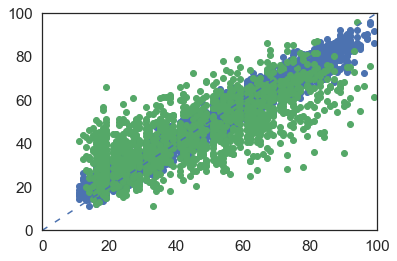

CV 2 : RMSE for training data: 2.854 / RMSE for validation data: 13.858 (n_trees: 497)


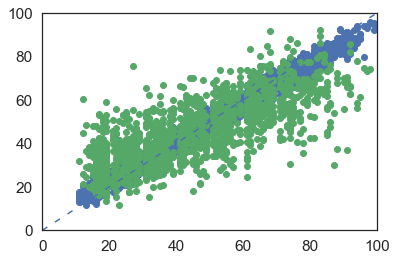

CV 3 : RMSE for training data: 5.494 / RMSE for validation data: 14.510 (n_trees: 271)


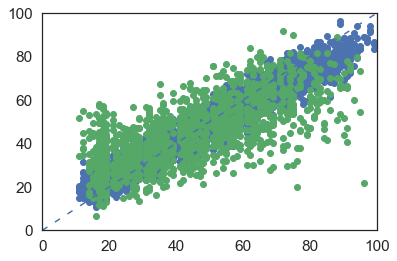

CV 4 : RMSE for training data: 5.724 / RMSE for validation data: 13.832 (n_trees: 257)


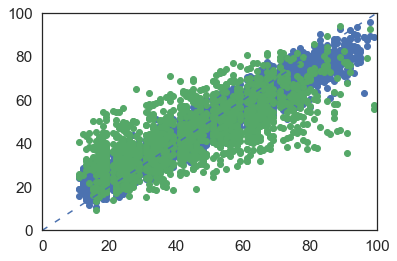

CV 5 : RMSE for training data: 2.934 / RMSE for validation data: 14.363 (n_trees: 469)


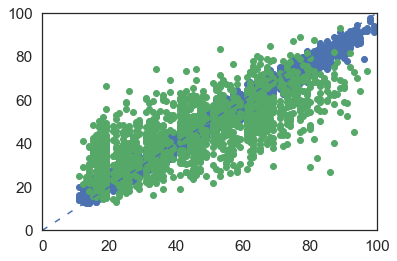

Cross-Validation RMSE: 14.081 +/- 0.588 (n_trees: 369)
Training data RMSE: 4.274 +/- 2.435 (n_trees: 369)


In [121]:
# Cross validation prediction with optimized hyperparameters
GridSearch_lgb_regressor(bottlenecks_filtered[features], bottlenecks_filtered["age"], param_grid_age, cv = 5, predict = False)

In [114]:
# Function to display memory usage of main datasets
def show_mem_usage():
    '''Displays memory usage from inspection
    of global variables in this notebook'''
    gl = sys._getframe(1).f_globals
    vars= {}
    for k,v in list(gl.items()):
        # for pandas dataframes
        if hasattr(v, 'memory_usage'):
            mem = v.memory_usage(deep=True)
            if not np.isscalar(mem):
                mem = mem.sum()
            vars.setdefault(id(v),[mem]).append(k)
        # work around for a bug
        elif isinstance(v,pd.Panel):
            v = v.values
        vars.setdefault(id(v),[sys.getsizeof(v)]).append(k)
    total = 0
    for k,(value,*names) in vars.items():
        if value>1e6:
            print(names,"%.2fMB"%(value/1e6))
        total += value
    print("%.2fMB"%(total/1e6))
    
show_mem_usage()

['wiki_metadata', 'wiki_metadata'] 12.84MB
['bottlenecks', 'bottlenecks'] 306.97MB
['bottlenecks_filtered', 'bottlenecks_filtered'] 114.59MB
434.78MB


In [152]:
del _51
del _52
del _50

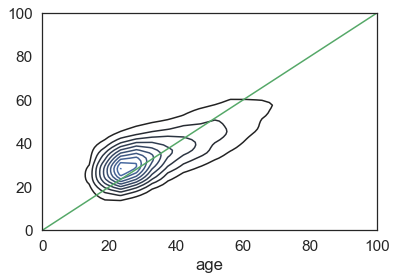

In [136]:
sns.kdeplot(bottlenecks["age"], predictions_age_train)
plt.plot([0,100], [0,100])
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

In [ ]:
cv = 5
df = verified_wiki
kfold = KFold(n_splits=cv, shuffle=True, random_state = 42)
counter_CV = 0
verified_wiki["correct_gender_probability"] = np.NaN
if not os.path.exists("./data/tmp/"):
    os.mkdir("./data/tmp/")
        
for gender in gender_bins:
    if not os.path.exists("./data/tmp/"+str(gender)):
        os.mkdir("./data/tmp/"+str(gender))

for train_index, val_index in kfold.split(df):
    counter_CV += 1
    print("CV iteration:", counter_CV)

    # Definition of training and validation sets for Kfold
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]
    # Moving each file into temporary folder
    print("Moving images into training folder")

    for index, row in train_df.iterrows():
        file_name = "./data/verified_gender/"+row["gender"]+"/"+row["new_file_name"]
        new_path = "./data/tmp/"+row["gender"]+"/"+row["new_file_name"]
        try:
            shutil.move(file_name, new_path)
        except:
            print("File missing :", file_name)

    print("Retraining classifier")
    output_graph = "./model_gender/retrained_graph.pb"
    output_labels = "./model_gender/output_labels.txt"
    final_tensor_name = "gender_model"
    image_dir = "./data/tmp/"
    
    FLAGS.how_many_training_steps = 500
    FLAGS.model_dir = "inception"
    FLAGS.output_graph = output_graph  
    FLAGS.output_labels = output_labels
    FLAGS.summaries_dir = ""
    FLAGS.final_tensor_name = final_tensor_name
    FLAGS.image_dir = image_dir
    retrain.FLAGS = FLAGS
    
    tf.logging.INFO = 1

    tf.app.run(main=retrain.main)
    
    print("Classifying validation data")
    model_file = output_graph
    label_file = output_labels
    input_height = 299
    input_width = 299
    input_mean = 0
    input_std = 255
    input_layer = "Placeholder"
    output_layer = final_tensor_name
    graph = label_image.load_graph("./model_gender/retrained_graph.pb")
    input_name = "import/" + input_layer
    output_name = "import/" + output_layer

    counter = 0
    prob_correct_label_list = []
    for index, row in val_df.iterrows():
        counter = counter + 1
        progress(counter, len(val_df))

        file_name = "./data/verified_gender/"+row["gender"]+"/"+row["new_file_name"]
    #  # with Image.open(file_name) as img:
    #    #   input_width, input_height = img.size

        t = label_image.read_tensor_from_image_file(
            file_name,
            input_height=input_height,
            input_width=input_width,
            input_mean=input_mean,
            input_std=input_std)
#
        input_operation = graph.get_operation_by_name(input_name)
        output_operation = graph.get_operation_by_name(output_name)
#
        with tf.Session(graph=graph) as sess:
            results = sess.run(output_operation.outputs[0], {
                input_operation.outputs[0]: t
            })
        results = np.squeeze(results)
#
        labels = label_image.load_labels(label_file)
        label = row["gender"]
#
        prob_correct_label = results[labels.index(label)]
        prob_correct_label_list.append(prob_correct_label)
        #if move_verified == True:
        #    if prob_correct_label >= criterion_verified:
        #        new_file_name = str(row.name)+"_"+row["name"]+"_"+row["gender"]+"_"+str(row["age"])+".jpg"
        #        new_path = "./data/verified_data/"+label+"/"+new_file_name
        #        shutil.copy(file_name, new_path)

    verified_wiki["correct_gender_probability"].iloc[val_index] = prob_correct_label_list
        
    print("Moving training images into verified folder")
    for index, row in train_df.iterrows():
        file_name = "./data/verified_gender/"+row["gender"]+"/"+row["new_file_name"]
        new_path = "./data/tmp/"+row["gender"]+"/"+row["new_file_name"]
        try:
            shutil.move(new_path, file_name)
        except:
            print("File missing :", new_path)

In [ ]:
def display_predictions(df, model, test_size, feature, legend_labels = None):
    train_train, train_val = train_test_split(df, test_size = test_size)
    train_train.is_copy = False
    train_val.is_copy = False
    list_values =sorted(df[df[feature].notnull()][feature].unique())

    model.fit(train_train[features_rf],  train_train[target])
    train_train["Predicted_proba_model"] = model.predict_proba(train_train[features_rf])[:,1]
    train_val["Predicted_proba_model"] = model.predict_proba(train_val[features_rf])[:,1]
    accuracy_train =  len(train_train[(train_train["Predicted_proba_model"].round() == train_train[target])])/len(train_train)
    accuracy_val =  len(train_val[(train_val["Predicted_proba_model"].round() == train_val[target])])/len(train_val)

    fig = plt.figure(figsize=(18,12))
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    g1 = sns.swarmplot(x = "Survived", y = "Predicted_proba_model", hue = feature, data = train_train, orient = "v", ax = ax1, hue_order = list_values, palette=pal, size = 7)
    g2 = sns.swarmplot(x = "Survived", y = "Predicted_proba_model", hue = feature, data = train_val, orient = "v", ax = ax2, hue_order = list_values, palette=pal, size = 7)
    ax1.axhline(0.5, label = "Survival cutoff", color = pal.as_hex()[2], dashes=[6, 6], xmin=0.05, xmax=0.95)
    ax2.axhline(0.5, label = "Survival cutoff", color = pal.as_hex()[2], dashes=[6, 6], xmin=0.05, xmax=0.95)
    ax1.set_ylabel("Predicted probability of survival", fontsize = 16)
    ax2.set_ylabel("Predicted probability of survival", fontsize = 16)
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax1.set_xticklabels(["Did not survive", "Survived"], fontsize = 16)
    ax2.set_xticklabels(["Did not survive", "Survived"], fontsize = 16)
    ax1.set_yticks([0.0, 0.5, 1.0])
    ax2.set_yticks([0.1, 0.5, 1.0])
    ax1.set_yticklabels(["0%", "50%", "100%"], fontsize = 16)
    ax2.set_yticklabels(["0%", "50%", "100%"], fontsize = 16)
    ax1.set_title("Predictions on training data (ovr. acc: %0.2f)" % accuracy_train, fontsize = 16)
    ax2.set_title("Predictions on validation data (ovr. acc: %0.2f)" % accuracy_val, fontsize = 16)
    list_labels_ax1 = ["Survival cutoff"]
    list_labels_ax2 = ["Survival cutoff"]

    for index, item in enumerate(list_values):
        df_train = train_train[train_train[feature] == item]
        df_val = train_val[train_val[feature] == item]
        accuracy_legend_train = len(df_train[(df_train["Predicted_proba_model"].round() == df_train[target])])/len(df_train) 
        accuracy_legend_val = len(df_val[(df_val["Predicted_proba_model"].round() == df_val[target])])/len(df_val) 
        if legend_labels == None:
            list_labels_ax1.append(str(item)+" (acc: "+str(round(accuracy_legend_train, 2))+")")
            list_labels_ax2.append(str(item)+" (acc: "+str(round(accuracy_legend_val,2))+")")
        else:
            list_labels_ax1.append(str(legend_labels[index]) +" (acc: %0.2f" % accuracy_legend_train+")")
            list_labels_ax2.append(str(legend_labels[index]) +" (acc: %0.2f" % accuracy_legend_val+")")

    ax1.legend(labels = list_labels_ax1, fontsize = 16, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol = 1, frameon=False)
    ax2.legend(labels = list_labels_ax2, fontsize = 16, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol = 1, frameon=False)
    # Correction of wrong color and size in legend
    for index, item in enumerate(list_values):
        ax1.legend_.legendHandles[index+1].set_color(pal.as_hex()[index])
        ax2.legend_.legendHandles[index+1].set_color(pal.as_hex()[index])
        ax1.legend_.legendHandles[index+1]._sizes = [49]
        ax2.legend_.legendHandles[index+1]._sizes = [49]
    ax1.set_facecolor("white")
    ax2.set_facecolor("white")
    sns.despine(bottom = True)
    plt.show()


In [ ]:
display_predictions(train, model = , test_size = 0.5, feature = "Sex")

In [367]:
# This function displays the images with the worst classification probability values
def display_worst_probability(df, feature, path_data, nb_images, width = 299, height = 299, best = False):
    if best == False:
        df = df.sort_values(by = ["correct_"+feature+"_probability"])[0:nb_images]
    else:
        df = df.sort_values(by = ["correct_"+feature+"_probability"], ascending = False)[0:nb_images]
    for index, row in df.iterrows():
        print(row["name"])
        print("Probability of", row[feature], "picture :", str(round(row["correct_"+feature+"_probability"]*100,1))+"%")
        im = PIL.Image.open(path_data+row[feature]+"/"+row["new_file_name"]).convert('RGBA')
        im = im.resize((width, height), PIL.Image.BILINEAR)
        plt.figure(figsize = (8,8))
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()

In [387]:
def display_predictions_sample(df, path_data, feature = "gender", model_gender=None, model_age=None, sample_size = 15, width = 299, height = 299, random_state = 1):
    fig = plt.figure(figsize = (20,14))
    axes = [fig.add_subplot(3, 5, i + 1) for i in range(sample_size)]
    counter = 0
    pal_GnRe = sns.blend_palette([pal[1], pal[3], pal[2]], 3)
    for index, row in df.sample(n=sample_size, random_state = random_state).iterrows():
        ax = axes[counter]
        counter += 1
        im = PIL.Image.open(row["new_path_gender"]).convert('RGBA')
        im = im.resize((width, height), PIL.Image.BILINEAR)
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")
        ax.text(10, -50, row["name"], verticalalignment = "center", horizontalalignment = "left", color = "black", size = 13)
        if row["correct_gender_probability_lgbm"] > 0.5:
            color_gender = pal.as_hex()[1]
            predicted_gender = row[feature]
            prediction_prob = row["correct_gender_probability_lgbm"]
        else:
            color_gender = pal.as_hex()[2]
            prediction_prob = 1 - row["correct_gender_probability_lgbm"]
            if row[feature] == "female":
                predicted_gender = "male"
                
            else:
                predicted_gender = "female"

        ax.text(10, -30, "Predicted gender: "+ predicted_gender +" ("+str(round(prediction_prob*100,1))+"%)", verticalalignment = "center", horizontalalignment = "left", color = color_gender, size = 12)
        error_color = min(2,abs(int((row["age"] - row["predicted_age_lgbm"])/5)))
        color_age = pal_GnRe.as_hex()[abs(error_color)]
        ax.text(10, -10, "Predicted age: "+str(round(row["predicted_age_lgbm"],1)) +" ("+"actual age: "+str(row["age"])+")", verticalalignment = "center", horizontalalignment = "left", color = color_age, size = 12)
    plt.subplots_adjust(wspace = 0.05, hspace = 0.2)
    plt.show()

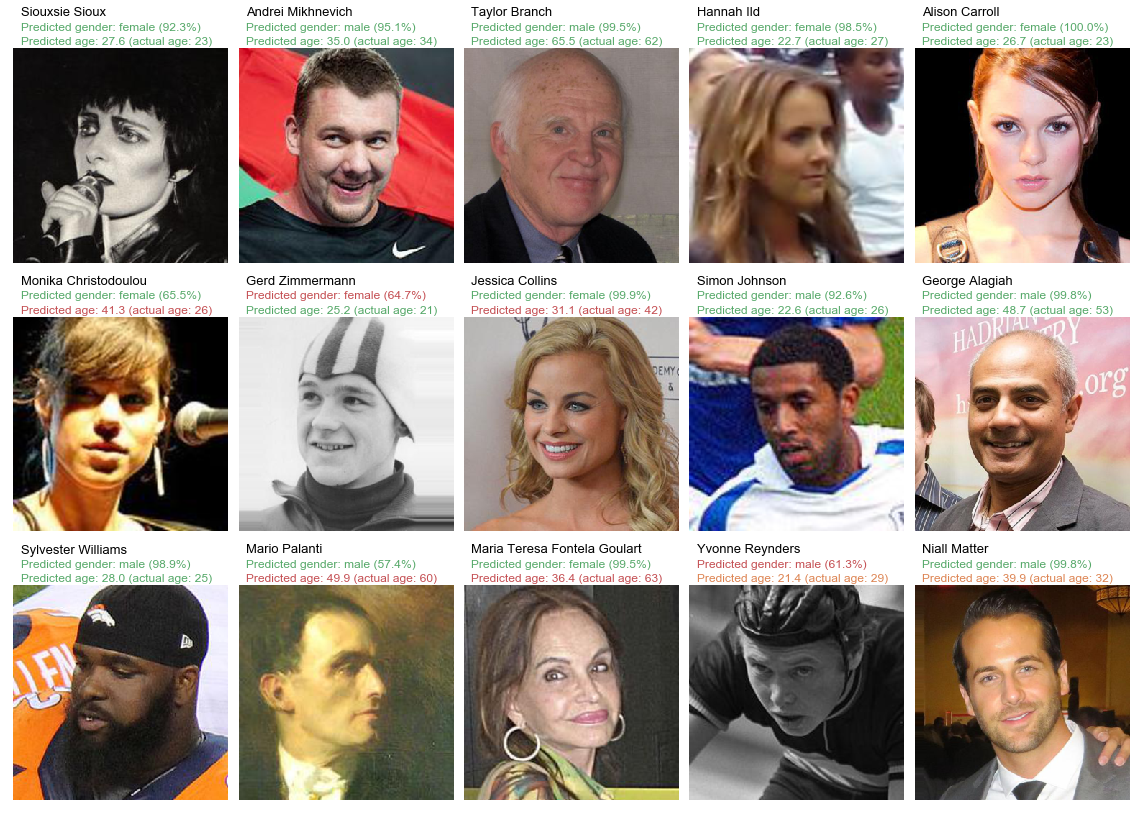

In [409]:
display_predictions_sample(wiki_metadata, path_data="./data/verified_gender/", sample_size = 15, random_state = 16)

In [455]:
good_random_states = 3, 6, 9, 14, 16

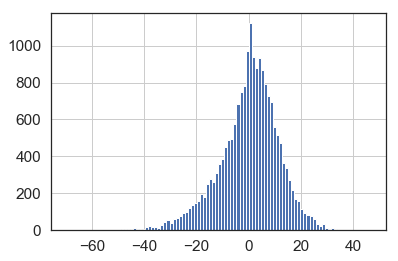

In [383]:
wiki_metadata["error_age"].hist(bins = 100)


In [378]:
# This function displays the images with the worst classification probability values
def display_worst_age_predictions(df, path_data, nb_images, width = 299, height = 299, best = False):
    if best == False:
        df = df.sort_values(by = ["absolute_error_age"], ascending = False)[0:nb_images]
    else:
        df = df.sort_values(by = ["absolute_error_age"])[0:nb_images]
    for index, row in df.iterrows():
        print(row["name"])
        print("Predicted age:", round(row["predicted_age_lgbm"],1), ("(actual age:"), str(row["age"])+")")
        im = PIL.Image.open(path_data+row["gender"]+"/"+row["new_file_name"]).convert('RGBA')
        im = im.resize((width, height), PIL.Image.BILINEAR)
        plt.figure(figsize = (8,8))
        plt.imshow(im)
        plt.xticks([])
        plt.yticks([])
        plt.show()

Ong Schan Tchow
Predicted age: 26.2 (actual age: 96)


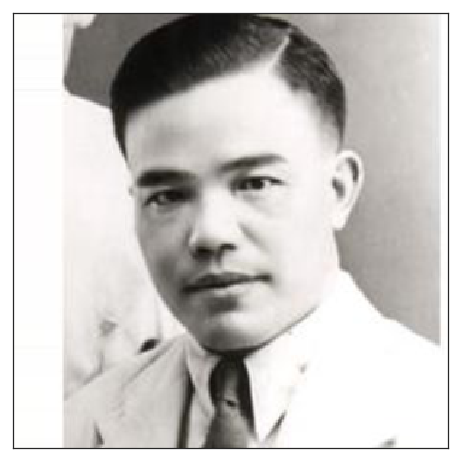

Fenella Fielding
Predicted age: 27.9 (actual age: 86)


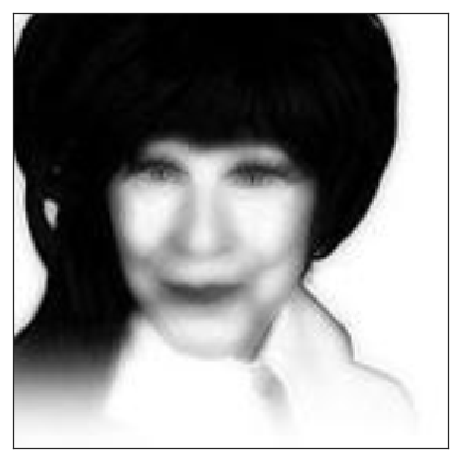

Robert Lee Moore
Predicted age: 35.2 (actual age: 91)


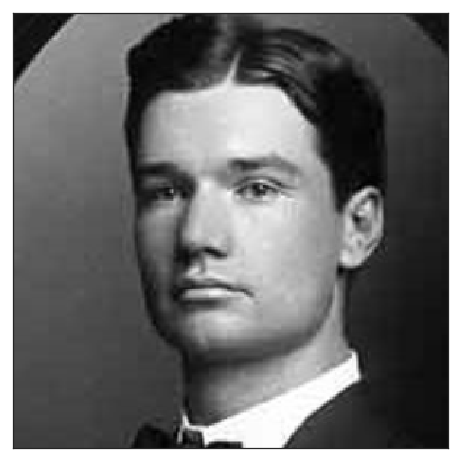

Stan Keller
Predicted age: 31.3 (actual age: 87)


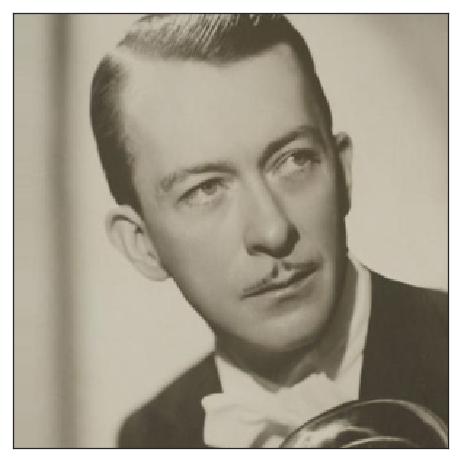

Arne Næss
Predicted age: 35.4 (actual age: 91)


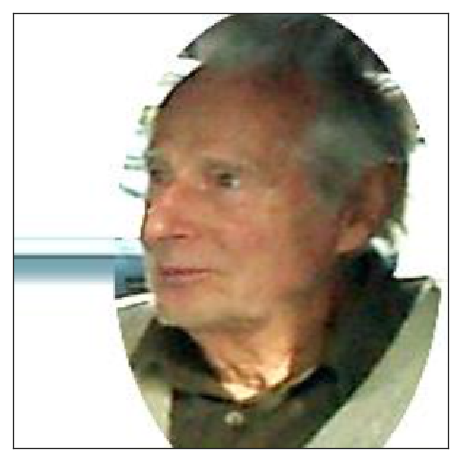

Verna M. Linzey
Predicted age: 39.7 (actual age: 95)


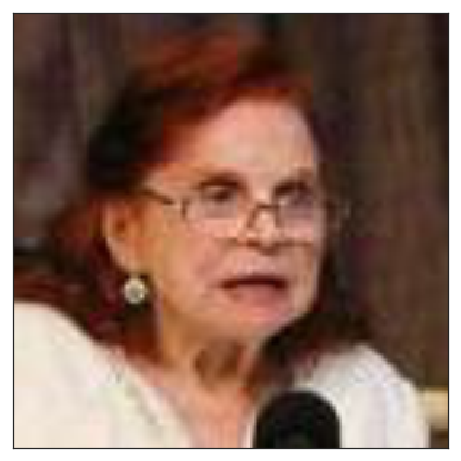

Pamela Cundell
Predicted age: 37.2 (actual age: 91)


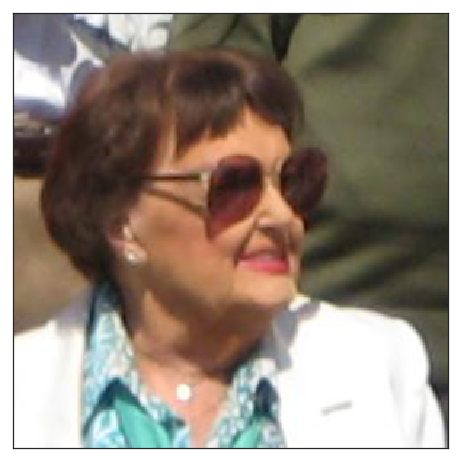

Elizabeth Goudge
Predicted age: 22.5 (actual age: 76)


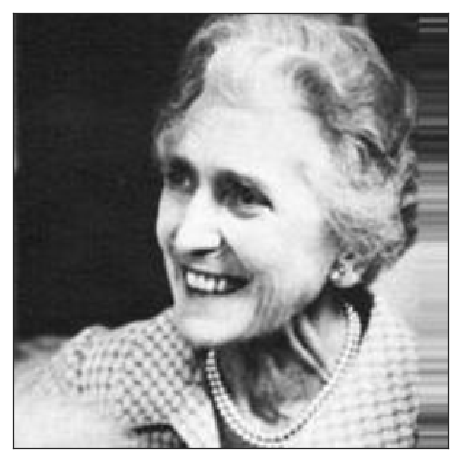

Chava Rosenfarb
Predicted age: 37.2 (actual age: 90)


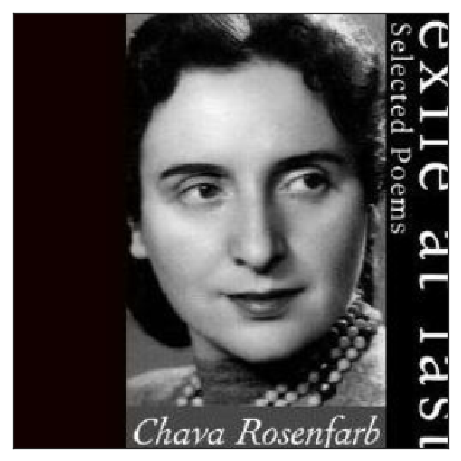

Helen Hooven Santmyer
Predicted age: 35.2 (actual age: 88)


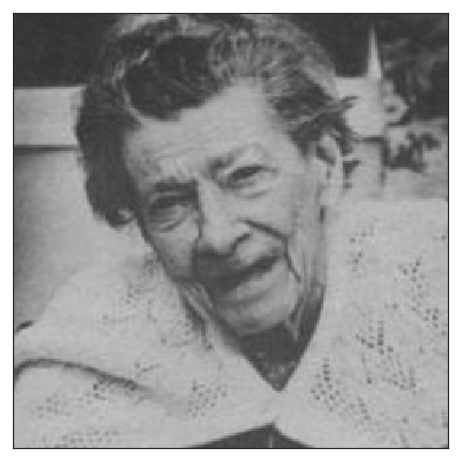

Ralph Kronig
Predicted age: 38.3 (actual age: 91)


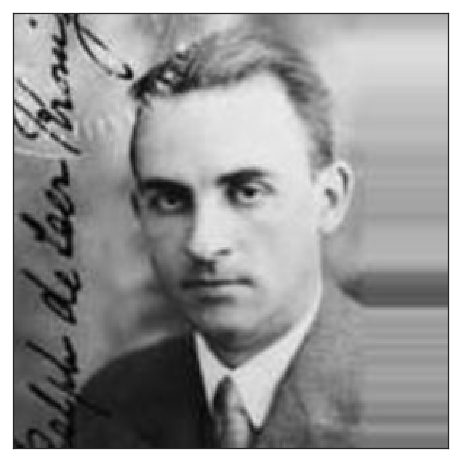

John R. Fox
Predicted age: 30.1 (actual age: 82)


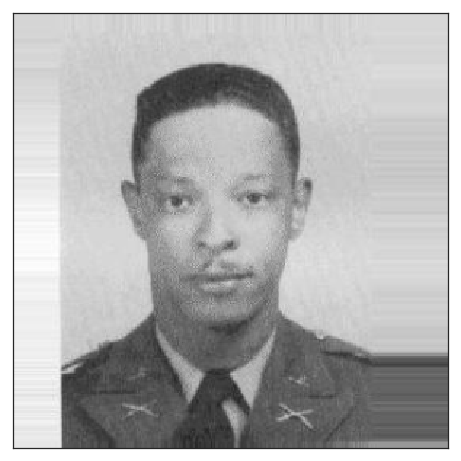

Jean Vallette d'Osia
Predicted age: 47.5 (actual age: 99)


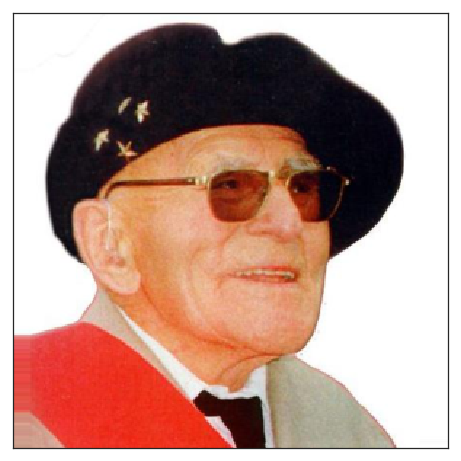

Kamala Sankrityayan
Predicted age: 36.7 (actual age: 88)


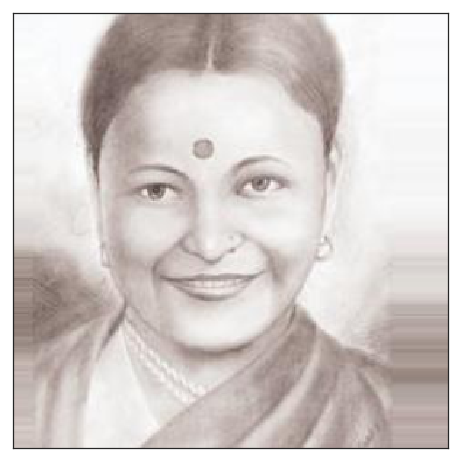

Maureen O'Hara
Predicted age: 42.1 (actual age: 93)


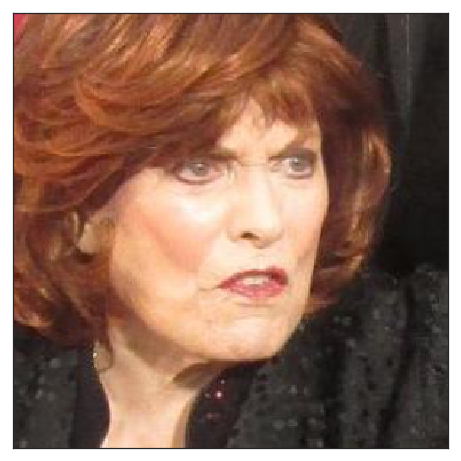

Myron Spaulding
Predicted age: 38.5 (actual age: 89)


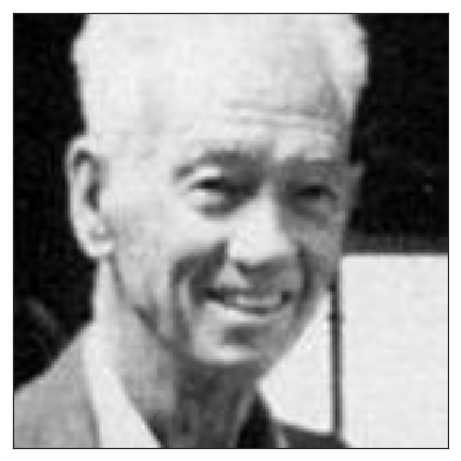

June Brown
Predicted age: 32.0 (actual age: 82)


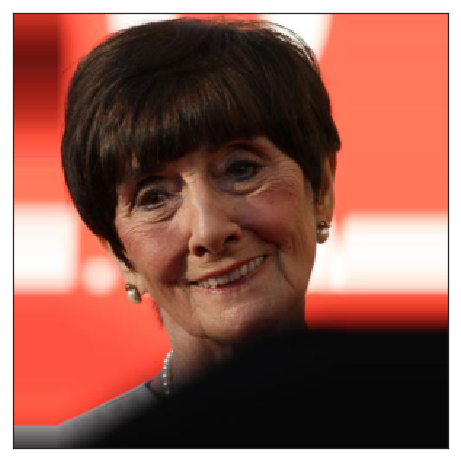

Fred Hawkins
Predicted age: 37.0 (actual age: 86)


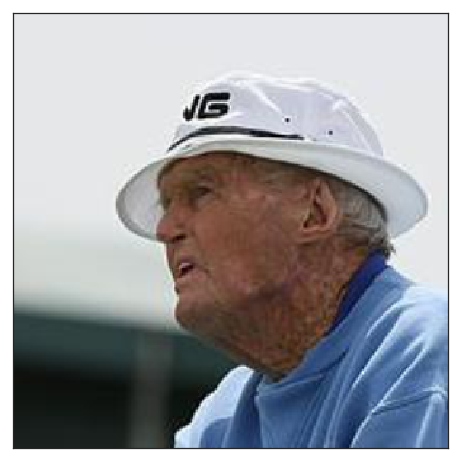

Jo Estill
Predicted age: 34.5 (actual age: 83)


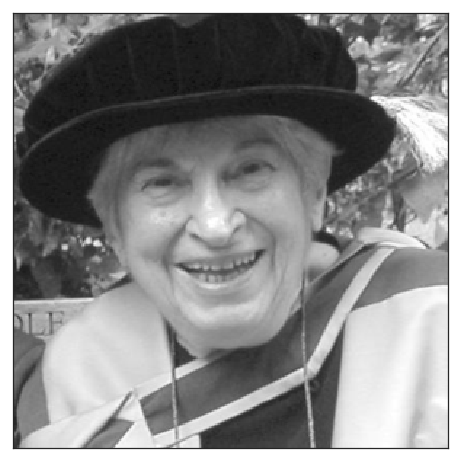

Anita O'Day
Predicted age: 36.5 (actual age: 85)


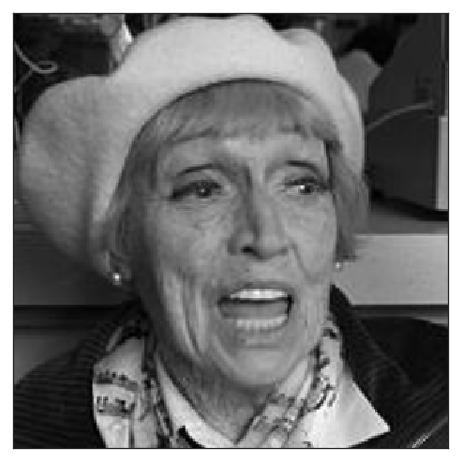

In [379]:
display_worst_age_predictions(wiki_metadata, path_data="./data/verified_gender/", nb_images=20, best = False)

In [ ]:
list_age_20s = wiki_

In [376]:
wiki_metadata["absolute_error_age"].describe()

count    19319.000000
mean         8.734755
std          7.555745
min          0.000023
25%          3.055482
50%          6.839559
75%         12.404376
max         69.826498
Name: absolute_error_age, dtype: float64